# Distributed Colour Concept Learning In Swarms
---
Five learning models, and agent-based update rules, are developed for populations of agents to find concepts through repeatedly playing the discimination language games. Each show emergent convergence for random concepts, and those grounded colour concepts from a dataset. Computational results find promising performance from quantum- mechanical agents. Data-streaming algorithms are introduced for agents to reason with infinite potential labels, and finite focal labels.


    
Quantum-inspired learning models differ from those suggested in the literature, and are proposed with local update rules. Their interpretations are discussed, and projection operator's subspaces appear to best model colour concepts.
    
Data-streaming algorithms are introduced for agents to reason with infinite potential labels, and finite focal labels. The Misra-Gries frequency estimation algorithm is adapted to enforce a degree of agreeability between agents before accepting new concepts. Focal colours are reliably learnt while agents use bounded space, and concept representation learning computation is limited to core categories.
    
Topics from quantum information theory and data-streaming algorithms infrequently used beyond their theoretic domains are explored to model colour concept learning in swarms on a dataset of natural language.

This notebook finds all results used in the final thesis, and is accompanied by commentary from the thesis.

# Set-up
Data from the [xkcd colour survey](https://blog.xkcd.com/2010/05/03/color-survey-results/) is loaded, and basic library imports along with colour scheme setup.

## Libraries import
Using special reload, so that don't have to restart whole notebook

In [1]:
%load_ext autoreload
%autoreload 2

# Importing Libraries
from agentClass import *
from discriminationGame import *
from learningModels import *
from metrics import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import pandas as pd
from tqdm.notebook import tqdm # This is such a cool library
from matplotlib import gridspec
from utilities import *
from pprint import pprint

from scipy.spatial import Voronoi, voronoi_plot_2d

## Graph Plotting settings

In [2]:
# LaTeX text
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## Colour Scheme

In [3]:
# My Colour scheme
#  every self-respecting/loathing millenial has their own, right?
orange = '#FFA500'
millenialPink = '#FFAADD'
mediumAquamarine = '#66CDAA'
uranianBlue = '#AFDBF5'
grey = '#ADADAD'

mediumAquamarine_0 = '#66CDAA00'
mediumAquamarine_1 = '#66CDAAFF'

millenialPink_0 = '#FFAADD00'
millenialPink_1 = '#FFAADDFF'

# Custom cmap
from matplotlib.colors import LinearSegmentedColormap

colours = [orange,millenialPink]
cm = LinearSegmentedColormap.from_list('customCmap', colours, N=1024)
cm_mp = LinearSegmentedColormap.from_list('customCmap_mp', [millenialPink_0,millenialPink_1], N=1024)
cm_ma = LinearSegmentedColormap.from_list('customCmap_mp', [mediumAquamarine_0,mediumAquamarine_1], N=1024)

### Import Data

In [4]:
# Load data, and shuffle
X = pd.read_csv('../DATA/XKCD/answers_202102041210.csv',header=None,names=['id','user_id','datestamp','r','b','g','colourname'])
X = np.array(X)
print(X.shape)
np.random.shuffle(X)
print(X[:10])

(1048576, 7)
[[121764 6764 1267464801 153 220 61 'lime green']
 [395240 18852 1267542437 94 19 13 'brown']
 [102855 5794 1267458740 108 148 46 'dark green']
 [233343 11770 1267486905 42 182 131 'bluey-green']
 [123908 6808 1267465466 183 215 217 'pale blue']
 [275896 13625 1267494929 161 51 26 'blood red']
 [953350 43447 1267755927 147 87 219 'lavender']
 [317228 15374 1267504148 149 80 190 'purple']
 [500049 23654 1267577440 243 60 160 'light purple']
 [962885 43759 1267761058 244 33 170 'fuschia']]


In [5]:
# Labels
# The eleven basic color terms
l = ['blue','green','red','orange','yellow','purple']
l = ['black','white','red','green','yellow','blue','brown','orange','pink','purple','grey']
l = ['red','green','yellow','blue','brown','orange','pink','purple','grey']

In [6]:
# Filter colours
r = 11000 # truncation value, to uniformly distribute colour labels
# use r=-1 for all
Xc = X[:,-1]
Xi = []
for k in l:
    x = np.where(Xc == k)
    Xi.extend(x[0][:r])
    print([len(x[0][:r]),k])
Xi = np.array(Xi) # Array of indices of labels in l
Y = X[Xi]
np.random.shuffle(Y)
print(Y.shape)
print(Y[:10])
# Y is the refined dataset

[11000, 'red']
[11000, 'green']
[11000, 'yellow']
[11000, 'blue']
[11000, 'brown']
[11000, 'orange']
[11000, 'pink']
[11000, 'purple']
[10970, 'grey']
(98970, 7)
[[792485 36494 1267661269 239 192 26 'yellow']
 [580185 27180 1267596474 81 252 62 'green']
 [733782 34018 1267643218 238 245 73 'yellow']
 [1010607 45976 1267781709 229 141 58 'orange']
 [563477 26482 1267594195 194 193 175 'grey']
 [534220 25050 1267587992 114 53 17 'brown']
 [1134 51 1267423843 167 103 74 'brown']
 [631631 29478 1267612387 220 203 106 'orange']
 [877613 40100 1267710796 52 215 86 'green']
 [680498 31756 1267629435 243 60 140 'pink']]


In [7]:
Y_train = Y[:10000]
Y_test = Y[-1000:]

# Exemplar Agents
Exemplar's represent categories with a single instance, $\vec{c}_t$. Their concept space produces a voronoi tesselation. A single shade exemplifies each colour concept.

## Agent Functions
Functions to create swarms of exemplar agents.

In [8]:
a_exemplar = 0.2

In [9]:
# Label Array - also used for quantum agent
ratioValue = 0
def RLA(l,pf,r=ratioValue,Y=Y_train):
    # r = ratio to use real data
    la = {l[i]:RE(pf) for i in np.random.randint(0,len(l),size=np.random.randint(0,len(l)))}
    for i in la:
        if np.random.random() < r:
            Xc = Y[:,-1]
            #print([i,str(i)])
            x = np.where(Xc == str(i))[0]
            #print(Xc[x])
            k = np.random.choice(x)
            la[i] = [float(Y[k,3])/255,float(Y[k,4])/255,float(Y[k,5])/255]
    return la
        

In [10]:
# Agents
def RA(pf,aArgs={'a':a_exemplar,'ratioValue':0},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    return Agent(ExemplarLearningModel(LA=RLA(l,pf,aArgs['ratioValue'],Y),a=a),pf=pf)

#Random Agent Array
def RAA(pf,N=5,aArgs={'a':a_exemplar,'ratioValue':0},l=l,Y=Y_train):
    agents = [RA(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

## Game playing functions
With example swarm creating functions, the functions to play discrimiantion games can be created.

In [11]:
def PF(n):
    return [[0 for i in range(n)],[1 for i in range(n)]] # put in square box

# This seems an ugly way to do it
def RE(playingField):
    return np.random.uniform(playingField[0],playingField[1])

# Play a round with a random selection of elements
def DiscriminationGameRound(A,B,pf,N=5):
    O = [RE(pf) for i in range(N)] # Random elements for N
    o = O[-1]
    DiscriminationGame(A,B,O,o)

In [30]:
nDG = 8 # nDifferentGames
nA = 32  # nAgents
nI = 128 # nIterations

In [118]:
# Game stuff

# Plays a single iteration of the disc. game
def GameRound(agents,pf):
    for A in agents:
        agents.remove(A)
        B = np.random.choice(agents)
        DiscriminationGameRound(A,B,pf)
        agents.append(A)

# Plays n iterations
def GameN(agents,pf,n=1):
    for i in range(n):
        GameRound(agents,pf)

# Returns results from multiple independent full games
# 'results' are the metric applied to the game, such as randomised agreement
def WholeGame(nDifferentGames=nDG,nAgents=nA,nIterations=nI,pf=PF(3),aArgs={'a':0.12,'ratioValue':0},RAA=RAA,Metric=RandomAccuracyMetric,metricAll=True,l=l,X_test=None,Y=Y_train):
    resultsWhole = []
    for i in range(nDifferentGames):
        agents = RAA(pf,nAgents,aArgs,l,Y)
        r = []
        for j in range(nIterations):
            GameRound(agents,pf)
            if metricAll or j == nIterations - 1: # Only record metric if record all or last iteration
                r.append(Metric(agents,X=X_test))
            #else if j == nIterations
        resultsWhole.append(r)
    return resultsWhole

# Plts the average over independent games, as well as their s.d.
def PltWholeGame(label,colour,nDifferentGames=nDG,nAgents=nA,nIterations=nI,pfn=3,aArgs={'a':0.12,'a_sd':6,'r':[0,0.75],'ratioValue':0},RAA=RAA,Metric=RandomAccuracyMetric,l=l,X_test=None,Y=Y_train):
    results = np.array(WholeGame(nDifferentGames,nAgents,nIterations,pf=PF(pfn),aArgs=aArgs,RAA=RAA,Metric=Metric,l=l,X_test=X_test,Y=Y))
    resultsAvg = np.mean(results,axis=0)
    resultsVar = np.sqrt(np.var(results,axis=0))
    plt.plot(range(resultsAvg.shape[0]),resultsAvg,c=colour,label=label)
    # Use a # of s.d.?
    plt.fill_between(range(resultsAvg.shape[0]),resultsAvg-resultsVar,resultsAvg+resultsVar,color=colour,alpha=0.25,linewidth=0.0)

In [33]:
# Functions same as above but with tqdm progress bars.
def WholeGame_prog(nDifferentGames=nDG,nAgents=nA,nIterations=nI,pf=PF(3),aArgs={'a':0.12,'ratioValue':0},RAA=RAA,Metric=RandomAccuracyMetric,metricAll=True,l=l,X_test=None,Y=Y_train):
    resultsWhole = []
    for i in tqdm(range(nDifferentGames)):
        agents = RAA(pf,nAgents,aArgs,l,Y)
        r = []
        for j in tqdm(range(nIterations),leave=False):
            GameRound(agents,pf)
            if metricAll or j == nIterations - 1: # Only record metric if record all or last iteration
                r.append(Metric(agents,X=X_test))
            #else if j == nIterations
        resultsWhole.append(r)
    return resultsWhole

def PltWholeGame_prog(label,colour,nDifferentGames=nDG,nAgents=nA,nIterations=nI,pfn=3,aArgs={'a':0.12,'a_sd':6,'r':[0,0.75],'ratioValue':0},RAA=RAA,Metric=RandomAccuracyMetric,l=l,X_test=None,Y=Y_train):
    results = np.array(WholeGame_prog(nDifferentGames,nAgents,nIterations,pf=PF(pfn),aArgs=aArgs,RAA=RAA,Metric=Metric,l=l,X_test=X_test,Y=Y))
    resultsAvg = np.mean(results,axis=0)
    resultsVar = np.sqrt(np.var(results,axis=0))
    plt.plot(range(resultsAvg.shape[0]),resultsAvg,c=colour,label=label)
    # Use a # of s.d.?
    plt.fill_between(range(resultsAvg.shape[0]),resultsAvg-resultsVar,resultsAvg+resultsVar,color=colour,alpha=0.25,linewidth=0.0)

## Exemplar Agent Space functions
Code to create Voronoi tesselations in two dimensional space, two model exemplar agents.

In [ ]:
# Temporary reduced labels for visulisation
l2 = ['obnoxious florg','deep flarg','millenial floof']
lc = {'obnoxious florg':mediumAquamarine,'deep flarg':orange,'millenial floof':millenialPink}

In [ ]:
def PlotVoroni(agent,ax,lc=lc):
    points = [agent.FindLabelExemplar(l) for l in agent.GetLabels()]
    points.append([100,100])
    points.append([-100,100])
    points.append([100,-100])
    points.append([-100,-100])
    vor = Voronoi(points)
    voronoi_plot_2d(vor,ax=ax,line_width=0,show_vertices=False)
    for r in vor.regions:
        if -1 not in r:
            p = [vor.vertices[j] for j in r]
           # print(p)
            if p:
                try:
                    ax.fill(*zip(*p),c=lc[agent.FindLabel(np.mean(p,axis=0))],alpha=0.25)
                except:
                    a = None
    for l in agent.GetLabels():
        x = agent.FindLabelExemplar(l)
        ax.plot([x[0]],[x[1]],color=lc[l],marker='.',markersize=10)
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

In [ ]:
def PlotVoroniCollage(agents,squareN=3,t=0):
    fig, axs = plt.subplots(squareN,squareN,figsize=(6,6))
    fig.suptitle("""$t=$"""+str(t),fontsize=20,weight=80)
    #plt.subplots_adjust(bottom=-.1,top=1) # This seems suuper dodge
    for i in range(squareN**2):
        PlotVoroni(agents[i],axs[i//squareN,i%squareN])
        axs[i//squareN,i%squareN].axis('off')
    #plt.show()
    return [fig,axs]

In [ ]:
def PlotVoroniCollageXY(agents,Y=3,X=3,t=0,fs=(15,15)):
    fig, axs = plt.subplots(Y,X,figsize=fs)
    gs = matplotlib.gridspec.GridSpec(Y,X,
         wspace=0.1, hspace=0.0, 
         top=1.-0.5/(X+1), bottom=0.5/(X+1), 
         left=0.5/(Y+1), right=1-0.5/(Y+1)) 
    #fig.suptitle("""$t=$"""+str(t),fontsize=20,weight=80)
    #plt.subplots_adjust(bottom=-.1,top=1) # This seems suuper dodge
    for y in range(Y):
        for x in range(X):
            i = x*X + y%Y
            #print([i,[x,y],[x%X,y*Y]])
            ax = plt.subplot(gs[y,x])
            PlotVoroni(agents[i],ax)
            ax.set_aspect('equal')
            ax.axis('off')
    #plt.show()
    return [fig,gs]

## Exemplar Agent Space Plots
Plotting Vorornoi tesselations for inane concepts.

In [ ]:
agents = RAA(PF(2),N=10,l=l2)
agentsD = {i:agents[i] for i in range(len(agents))}
agents = [agentsD[i] for i in range(len(agents))]

In [ ]:
fig,axs = PlotVoroniCollage(agentsD,t=0)
#fig,axs = PlotVoroniCollageXY(agents,30,20,t=0,fs=(8.25,11.75))
plt.tight_layout()
fig.savefig('./Images/Exemplar/collage_0.pdf', transparent=False)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
GameN(agents,PF(2),n=3)

In [ ]:
GameN(agents,PF(2),n=3)
fig,axs = PlotVoroniCollage(agentsD,t=4)
plt.tight_layout()
fig.savefig('./Images/Exemplar/collage_4.pdf',transparent=False)
plt.show()

In [ ]:
GameN(agents,PF(2),n=60)
fig,axs = PlotVoroniCollage(agents,t=64)
plt.tight_layout()
fig.savefig('./Images/Exemplar/collage_64.pdf',transparent=False)
plt.show()

## Find learning rate
Learning rate, $\alpha$, is found through many games. Both inanely, and on the dataset.

In [ ]:
# Randomised convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1,num=50)
results = np.array([np.array(WholeGame(nAgents=128,aArgs={'a':i,'ratioValue':0},Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in ls])
results_t = np.array([np.array(WholeGame(nAgents=128,aArgs={'a':i,'ratioValue':1},Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in ls])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.125,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.125,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Agent Exemplar Metric')
# Legend
rando = matplotlib.patches.mlines.Line2D([], [], color=millenialPink, marker='.',alpha=0.125, label='Randomly Initialised')
truth = matplotlib.patches.mlines.Line2D([], [], color=orange, marker='.',alpha=0.125, label='Initialised from Training data')
plt.legend(handles=[rando,truth])
#plt.savefig('./Images/learningRate_exemplar_randmoised.pdf')
plt.show()

In [ ]:
rando = plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.125,label='Random')
truth = plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.125,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Agent Exemplar Metric')
# Legend
rando = matplotlib.patches.mlines.Line2D([], [],color='w', markerfacecolor=millenialPink, marker='.',alpha=0.75, label='Randomly Initialised')
truth = matplotlib.patches.mlines.Line2D([], [],color='w', markerfacecolor=orange, marker='.',alpha=0.75, label='Initialised from Training data')
plt.legend(handles=[rando,truth])
plt.savefig('./Images/learningRate_exemplar_randmoised.pdf')
plt.show()

In [ ]:
# Randomised convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1,num=50)
results = np.array([np.array(WholeGame(aArgs={'a':i,'ratioValue':0},Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in ls])
results_t = np.array([np.array(WholeGame(aArgs={'a':i,'ratioValue':1},Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in ls])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.125,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.125,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Agent Exemplar Metric')
#plt.savefig('./Images/learningRate_exemplar_randmoised.pdf')
plt.show()

In [ ]:
# Training convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1,num=50)
results = np.array([np.array(WholeGame(aArgs={'a':i,'ratioValue':0},Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in ls])
results_t = np.array([np.array(WholeGame(aArgs={'a':i,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in ls])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Agent Exemplar Metric')
plt.savefig('./Images/learningRate_exemplar_testing.pdf')
plt.show()

In [ ]:
a_exemplar = 0.2 # From these findings we prorpose this as the learning rate to use, but should we?

### Truth Conververgence 
For an exemplar model investigate the imapct of inilisation with truth values on generalised random agreement convergence.

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('Complete Random',millenialPink,nDifferentGames=32,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':0},Metric=RandomAccuracyMetric)
PltWholeGame('Half Truth',mediumAquamarine,nDifferentGames=32,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':0.5},Metric=RandomAccuracyMetric)
PltWholeGame('Full Truth',orange,nDifferentGames=32,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':1},Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Prototype Agents')
plt.legend()
plt.savefig('./Images/truthPlot_exemplar.pdf')
plt.show()
# Plot point where cross with complete random?
# More games to see if full truth is truly detrimental long term
# 45 mins for 256 iterations

In [ ]:
# Full look at truth rates
ls = np.linspace(0,1,num=50)
results = np.array([np.array(WholeGame(nDifferentGames=128,nIterations=32,aArgs={'a':a_exemplar,'ratioValue':i},Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in ls])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25)
plt.xlabel('Truth Rate')
plt.ylabel('Randomised Convervgence Metric')
plt.savefig('./Images/truthConv.png')
plt.show()

In [ ]:
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.02)
plt.plot(ls,np.mean(results,axis=1),c=millenialPink)
plt.xlabel('Truth Rate')
plt.ylabel('Randomised Convervgence Metric')
plt.savefig('./Images/truthConv.png')
plt.show()

### Number of agents

In [ ]:
# Agents
PltWholeGame('5 Agents',millenialPink,nAgents=5)
PltWholeGame('10 Agents',mediumAquamarine,nAgents=10)
PltWholeGame('25 Agents',orange,nAgents=25)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.legend()
plt.savefig('./Images/agents.png')
plt.show()

In [ ]:
%%timeit -n 1 -r 1
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1,num=50)
results = np.array([np.array(WholeGame(aArgs={'a':i},Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in ls])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25)
plt.xlabel('Learning Rate')
plt.ylabel('RandomAccuracyMetric')
plt.savefig('./Images/learningRate_r.png')
plt.show()

## Variable finding Heatmaps
Further exploring the impact of learning paramters on optimal learning rate, e.g. what is the effect of higher dimensions or more agents on best learning rate. Little discussed in the report.

In [ ]:
# Stolen from online
#  https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=cm_mp,
                          precision=3,
                          xLabel='',
                          yLabel=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.colorbar()
    #tick_marks = )
    plt.xticks(np.arange(len(classes[0])), np.around(classes[0],3), rotation=45)
    plt.yticks(np.arange(len(classes[1])), np.around(classes[1],3))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, round(cm[i, j],precision),
                     horizontalalignment="center",
                     color="black",fontsize=18)# if cm[i, j] > thresh else "black")

    plt.tight_layout()

In [ ]:
#%%timeit -n 1 -r 1
# Dimensions x Learning rate
lr = np.linspace(0,1,11)
dimensions = list(range(1,9))
plt.rcParams.update({'font.size': 18})
results = np.array([[np.mean(np.array(WholeGame(pf=PF(d),nIterations=1024,aArgs={'a':x},metricAll=False,Metric=RandomAccuracyMetric))) for d in dimensions] for x in lr])
plot_confusion_matrix(results,[dimensions,lr],title='Convergence Heatmap Using Randomised Accuracy Metric',xLabel='Dimensions',yLabel='Learning Rate')
plt.savefig('./Images/heatmap_dimXLearning_r_1024.png')

In [ ]:
plot_confusion_matrix(results,[dimensions,lr],title='Convergence Heatmap Using Randomised Accuracy Metric',xLabel='Dimensions',yLabel='Learning Rate')
plt.savefig('./Images/heatmap_dimXLearning_r_1024.png')

In [ ]:
%%timeit -n 1 -r 1
# Dimensions x Learning rate
lr = np.linspace(0,1,11)
dimensions = list(range(1,9))
results = np.array([[np.mean(np.array(WholeGame(pf=PF(d),aArgs={'a':x},metricAll=False))) for d in dimensions] for x in lr])
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(results,[dimensions,lr],title='Convergence Heatmap',xLabel='Dimensions',yLabel='Learning Rate')
plt.savefig('./Images/heatmap_dimXLearning.png')

In [ ]:
%%timeit -n 1 -r 1
# Dimensions x Labels
labels = list(range(1,6))
dimensions = list(range(1,9))
results = np.array([[np.mean(np.array(WholeGame(pf=PF(d),l=l[:x],metricAll=False,Metric=RandomAccuracyMetric))) for d in dimensions] for x in labels])
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(results,[dimensions,labels],title='Convergence Heatmap',xLabel='Dimensions',yLabel='Number of Labels')
plt.savefig('./Images/heatmap_dimXLlabels_r.png')

In [ ]:
#%%timeit -n 1 -r 1
# Dimensions x Labels
labels = list(range(1,6))
dimensions = list(range(1,9))
plt.rcParams.update({'font.size': 18})
results = np.array([[np.mean(np.array(WholeGame(pf=PF(d),l=l[:x],metricAll=False))) for d in dimensions] for x in labels])
plot_confusion_matrix(results,[dimensions,labels],title='Convergence Heatmap',xLabel='Dimensions',yLabel='Number of Labels')
plt.savefig('./Images/heatmap_dimXLlabels.png')

In [ ]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(results,[dimensions,labels],title='Convergence Heatmap',xLabel='Dimensions',yLabel='Number of Labels')
plt.tight_layout()
plt.savefig('./Images/heatmap_dimXLabels_tl.png')

In [ ]:
%%timeit -n 1 -r 1
# Dimensions x Learning rate
lr = np.linspace(0,1,11)
labels = list(range(1,6))
results = np.array([[np.mean(np.array(WholeGame(l=l[:y],aArgs={'a':x},metricAll=False,Metric=RandomAccuracyMetric))) for y in labels] for x in lr])
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(results,[labels,lr],title='Convergence Heatmap',xLabel='Labels',yLabel='Learning Rate')
plt.savefig('./Images/heatmap_labelsXLearning_r.png')

In [ ]:
%%timeit -n 1 -r 1
lr = np.linspace(0,1,11)
labels = list(range(1,6))
results = np.array([[np.mean(np.array(WholeGame(l=l[:y],aArgs={'a':x},metricAll=False))) for y in labels] for x in lr])
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(results,[labels,lr],title='Convergence Heatmap',xLabel='Labels',yLabel='Learning Rate')
plt.savefig('./Images/heatmap_labelsXLearning.png')

# Classical Prototype Agents
This prototype learning model define a Gaussian distribution for each label. A colour concept becomes a centroid shade, and a standard deviation.

## Prototype Agent Functions

In [15]:
def RSD(r=[0,1]):
    return np.random.uniform(low=r[0],high=r[1])

In [16]:
def RLA_bp(l,pf,r,ratioValue=0,Y=Y_train):
    # r = ratio to use real data
    la = {l[i]:{'c':RE(pf),'sd':RSD(r)} for i in np.random.randint(0,len(l),size=np.random.randint(0,len(l)))}
    for i in la:
        if np.random.random() < ratioValue:
            Xc = Y[:,-1]
            x = np.where(Xc == i)[0]
            #print(Xc[x])
            k = np.random.choice(x)
            la[i]['c'] = [float(Y[k,3])/255,float(Y[k,4])/255,float(Y[k,5])/255]
    return la

In [17]:
# Agents_BayesianPrototype
def RA_bp(pf,aArgs={'a':0.18,'a_sd':8,'r':[0,0.75],'ratioValue':0},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    a_sd = aArgs['a_sd']
    r = aArgs['r']
    return Agent(BayesianPrototypeLearningModel(LA=RLA_bp(l,pf,r,aArgs['ratioValue'],Y),a=a,a_sd=a_sd),pf=pf)

#Random Agent Array
def RAA_bp(pf,N=5,aArgs={'a':0.18,'a_sd':0.6,'r':[0,0.75],'ratioValue':0},l=l,Y=Y_train):
    agents = [RA_bp(pf,aArgs,l=l,Y=Y) for i in range(N)] # an array of N random agents
    return agents

In [18]:
# => conclude on a
a_prototype = 0.18
a_sd_prototype = 0.25

## Prototype Agent Space
Gaussian distributions create non-linear decisions boundaries, and therefore instead a plot that demonstrates each Gaussian distribution is given instead. 

In [ ]:
# Function to plot a gradient marker
def PlotGradientMarker_bp(agent,ax,colours=lc,N=100):
    # Axis off doesn't seem to work and iu can't work out why so here's loads of weird stuff
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    j = 0
    for l in agent.GetLabels():
        c = agent.learningModel.LA[l]['c']
        s = agent.learningModel.LA[l]['sd']
        #for i in range(N):
        #   # Axis off doesn't seem to work and iu can't work out why so here's loads of weird stuff
        #    ax.plot([c[0]],[c[1]],color=colours[l],marker='.',markersize=800*s*i/N,alpha=.75/N)
        #    #ax.axis('off')
        ax.plot([c[0]],[c[1]],color=colours[l],marker='.',markersize=10)
        ax.plot([c[0]],[c[1]],color=colours[l],marker='.',markersize=500*s,alpha=.25)
        j += 1
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

In [ ]:
def PlotBPCollage(agents,squareN=3,t=0):
    fig, axs = plt.subplots(squareN,squareN,figsize=(6,6))
    fig.suptitle("""$t=$"""+str(t),fontsize=20,weight=80)
    #plt.subplots_adjust(bottom=-.1,top=1) # This seems suuper dodge
    for i in range(squareN**2):
        PlotGradientMarker_bp(agents[i],axs[i//squareN,i%squareN])
        #axs[i//squareN,i%squareN].axis('off')
    plt.show()
    return [fig,axs]

In [ ]:
l2 = ['obnoxious florg','deep flarg','millenial floof']
lc = {'obnoxious florg':mediumAquamarine,'deep flarg':orange,'millenial floof':millenialPink}
print(l)

In [ ]:
# Do some checks that this works as expected?
pf = PF(2)
agents = RAA_bp(pf,N=9,l=l2)
agentsD = {i:agents[i] for i in range(len(agents))}
agents = [agentsD[i] for i in range(len(agents))]
fig,axs = PlotBPCollage(agentsD)
plt.tight_layout()
fig.savefig('./Images/Prototypes/collage_0.pdf',transparent=False)

In [ ]:
GameN(agents,PF(2),3)
fig,axs = PlotBPCollage(agentsD,t=4)
plt.tight_layout()
fig.savefig('./Images/Prototypes/collage_4.pdf',transparent=False)
GameN(agents,PF(2),60)
fig,axs = PlotBPCollage(agentsD,t=64)
plt.tight_layout()
fig.savefig('./Images/Prototypes/collage_64.pdf',transparent=False)
GameN(agents,PF(2),64)
fig,axs = PlotBPCollage(agentsD,t=128)
#fig.savefig('./Images/Prototypes/collage_128.pdf')
GameN(agents,PF(2),128)
fig,axs = PlotBPCollage(agentsD,t=256)
#fig.savefig('./Images/Prototypes/collage_256.pdf')

In [ ]:
GameN(agents,PF(2),60)
fig,axs = PlotBPCollage(agents,t=64)

## Find Learning Rates
The prototype learning model needs two learning rates. The exemplar learning rate is first assumed for centroid learning, and standard deviation rate found. Using the new standard deviation learning rate a new centroid learning rate is then found.

In [ ]:
# Randomised convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,2,num=51)
results = np.array([np.array(WholeGame(nIterations=128,nDifferentGames=1,nAgents=64,aArgs={'a':a_exemplar,'a_sd':i,'r':[0,.75],'ratioValue':0},RAA=RAA_bp,Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])
results_t = np.array([np.array(WholeGame(nIterations=128,nDifferentGames=1,nAgents=64,aArgs={'a':a_exemplar,'a_sd':i,'r':[0,.75],'ratioValue':1},RAA=RAA_bp,Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Randomised Convergence Metric')
plt.savefig('./Images/learningRate_prototype_randmoised.pdf')
plt.show()

In [ ]:
# Training convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,2,num=21)
results = np.array([np.array(WholeGame(nIterations=128,nDifferentGames=4,nAgents=64,aArgs={'a':a_exemplar,'a_sd':i,'r':[0,.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_t = np.array([np.array(WholeGame(nIterations=128,nDifferentGames=4,nAgents=64,aArgs={'a':a_exemplar,'a_sd':i,'r':[0,.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Agent Exemplar Metric')
plt.savefig('./Images/learningRate_exemplar_testing.pdf')
plt.show()

In [24]:
# => conclude on a_sd
a_sd_prototype = 0.25

In [ ]:
# Training convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1,num=21)
results = np.array([np.array(WholeGame(nIterations=128,nDifferentGames=4,nAgents=64,aArgs={'a':i,'a_sd':a_sd_prototype,'r':[0,.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_t = np.array([np.array(WholeGame(nIterations=128,nDifferentGames=4,nAgents=64,aArgs={'a':i,'a_sd':a_sd_prototype,'r':[0,.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Testing Agreement Metric')
plt.show()

In [23]:
# => conclude on a
a_prototype = 0.18

## Plots
Random plots that were used in investigation, but never appeared in final report. It was found that the number of labels, dimensionality, and number of agents, all adversely affected convergence of the swarm.

In [ ]:
# Dimensions
PltWholeGame('2d',millenialPink,pfn=2,RAA=RAA_bp,Metric=RandomAccuracyMetric)
PltWholeGame('3d',mediumAquamarine,pfn=3,RAA=RAA_bp,Metric=RandomAccuracyMetric)
PltWholeGame('5d',orange,pfn=5,RAA=RAA_bp,Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Randomised Convergence Metric')
plt.legend()
plt.savefig('./Images/dimPlot_bp.pdf')
plt.show()

In [ ]:
# Truths
PltWholeGame('Complete Random',millenialPink,nDifferentGames=128,nIterations=128,aArgs={'a':0.12,'a_sd':1.15,'r':[0,0.75],'ratioValue':0},Metric=RandomAccuracyMetric,RAA=RAA_bp)
PltWholeGame('Half Truth',mediumAquamarine,nDifferentGames=128,nIterations=128,aArgs={'a':0.12,'a_sd':1.15,'r':[0,0.75],'ratioValue':0.5},Metric=RandomAccuracyMetric,RAA=RAA_bp)
PltWholeGame('Full Truth',orange,nDifferentGames=128,nIterations=128,aArgs={'a':0.12,'a_sd':1.15,'r':[0,0.75],'ratioValue':1},Metric=RandomAccuracyMetric,RAA=RAA_bp)
plt.xlabel('Iterations')
plt.ylabel('Randomised Convergence Metric')
plt.title('Randomised convergence of Gaussian Prototype Agents')
plt.legend()
plt.savefig('./Images/truthPlot_bp.pdf')
plt.show()

In [ ]:
# Dimensions: Bayesian vs. Exemplar
#PltWholeGame('Exemplar',millenialPink,nIterations=1024,Metric=RandomAccuracyMetric)
#PltWholeGame('Gaussian Prototype',mediumAquamarine,nIterations=1024,RAA=RAA_bp,Metric=RandomAccuracyMetric)
#plt.xlabel('Iterations')
#plt.ylabel('Randomised Convergence Metric')
#plt.legend()
#plt.savefig('./Images/bpVsExemplar.png')
#plt.show()

In [ ]:
#%%timeit -n 1 -r 1
# Dimensions x Learning rate (centroid)
lr = np.linspace(0,1,11)
dimensions = list(range(1,11))
results = np.array([[np.mean(np.array(WholeGame(pf=PF(d),aArgs={'a':x,'a_sd':a_sd_prototype},RAA=RAA_bp,metricAll=False,Metric=RandomAccuracyMetric))) for d in dimensions] for x in lr])
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(results,[dimensions,lr],title='Convergence Heatmap',xLabel='Dimensions',yLabel='Learning Rate')
plt.savefig('./Images/heatmap_learningXDim_bp.png')

In [ ]:
plot_confusion_matrix(results.T,[lr,dimensions],title='Convergence Heatmap',xLabel='Learning Rate',yLabel='Dimensions')
plt.savefig('./Images/heatmap_learningXDim_bp.png')

In [ ]:
# Learning rate x Learning rate
lr = np.linspace(0,1,11)
lr_sd = np.linspace(0,10,11)
results = np.array([[np.mean(np.array(WholeGame(nDifferentGames=100,aArgs={'a':i,'a_sd':j,'r':[0,1]},RAA=RAA_bp,metricAll=False,Metric=RandomAccuracyMetric))) for j in lr_sd] for i in lr])
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(results,[lr_sd,lr],title='Convergence Heatmap',xLabel='Prototypicality Learning Rate',yLabel='Learning Rate',cmap=cm_mp)
plt.savefig('./Images/heatmap_learningRates_bp.png')

In [ ]:
#lr = np.linspace(0,1,11)
#lr_sd = np.linspace(0,10,11)
#plot_confusion_matrix(results,[lr_sd,lr],title='Convergence Heatmap using Randomised Accuracy Metric',xLabel='Prototypicality Learning Rate',yLabel='Learning Rate',cmap=cm_mp)
#plt.savefig('./Images/heatmap_learningRates_bp.png')

In [ ]:
# My Colour scheme
#  every self-respecting/loathing millenial has their own, right?
orange = '#FFA500'
millenialPink = '#FFAADD'
mediumAquamarine = '#66CDAA'

mediumAquamarine_0 = '#66CDAA00'
mediumAquamarine_1 = '#66CDAAFF'

millenialPink_0 = '#FFAADD00'
millenialPink_1 = '#FFAADDFF'

# Custom cmap
from matplotlib.colors import LinearSegmentedColormap

colours = [orange,millenialPink]
cm = LinearSegmentedColormap.from_list('customCmap', colours, N=1024)
cm_mp = LinearSegmentedColormap.from_list('customCmap_mp', [millenialPink_0,millenialPink_1], N=1024)
cm_ma = LinearSegmentedColormap.from_list('customCmap_mp', [mediumAquamarine_0,mediumAquamarine_1], N=1024)

In [ ]:
#%%timeit -n 1 -r 1
# Dimensions x Learning rate
lr = np.linspace(0,1,11)
dimensions = list(range(1,9))
plt.rcParams.update({'font.size': 18})
results_bp = np.array([[np.mean(np.array(WholeGame(pf=PF(d),nIterations=256,aArgs={'a':x,'a_sd':1.15,'r':[0,1]},RAA=RAA_bp,metricAll=False,Metric=RandomAccuracyMetric))) for d in dimensions] for x in lr])
plot_confusion_matrix(results_bp,[dimensions,lr],title='Convergence Heatmap Using Randomised Accuracy Metric',xLabel='Dimensions',yLabel='Learning Rate')
plt.savefig('./Images/heatmap_dimXLearning_r_bp.png')

# Quantum-Inspired Agents
The similarity of prototype theory’s state ensembles and quantum density matrices, representing colour in a quantum-mechanical space (like the one we live in), and the literature proposing quantum probability to explain psychological evidence dissuading cognition using Kolomogov probability have all influenced the following quantum models.

The three quantum-inspired approaches explore qubit-colour representations and the utlilty of different operator types in modelling concepts - with the main focus on the relation between statistical description in-built to quantum states and that proposed by Rosch’s prototype theory of concepts. While models are introduced and their emergent convergence is observed in swarms, it is advocated that further study look at the inbuilt mathematical descriptions of quantum mechanics to, for example, explore; hedging, or conjunction, through the combination of density matrices, qubit collapse on measurement for consecutive questions, and entanglement in speaker-listener objects.

Experimental results have suggested that human cognition can contradict classical probability, and hence quantum-theoretic modelling has been introduced in the literature to better model human agents. Psychologically, it is well justified to suggest models of cognition, and then concept learning should in least explore a quantum explanation.

The current most-compelling description of the physical world exhibits quantum phenomena; entanglement, interference, and collapse. Intelligence is a subject of language, and our language is a subject of our world. In modelling language development in pursuit of artificial intelligence it seems only apt to suggest its power may lay in its environment and to advocate it must leverage the imaginary realm. Placing colour vectors onto a Bloch sphere, quantum based language-game playing agents can create concepts that can collapse, interfere, and be spooky . There exists formalisms in quantum physics that may model psychologically-important learning mechanisms.

All quantum learning models use the single qubit representation of colour to limit computaation

As the minimal quantum expansion, or quantum leap, in concept modelling, the Quantum Vector Exemplar, QVE, model presents concepts as a single state on a hyper-Bloch-sphere. Similarly to the previous exemplar model, a single instance is stored and the membership function is calculated through a similarity function.

In [27]:
a_quantumv = 0.2

In [28]:
def RA_quantumv(pf,aArgs={'a':a_quantumv,'ratioValue':0},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    return Agent(QuantumVectorAgent(LA=RLA(l,pf,aArgs['ratioValue'],Y),a=a),pf=pf)

#Random Agent Array
def RAA_quantumv(pf,N=5,aArgs={'a':a_quantumv,'ratioValue':0},l=l,Y=Y_train):
    agents = [RA_quantumv(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

Quantum mechanics defines density matrices that describe the statistical state of a quantum system. Qubits differ to classical bits through their superposition putting them in statistical combinations. To classify an instance, a colour vector, the concept with the density matrix, $\rho_t$, that returns the highest measurement is returned. A measurement on the density matrix is the probability that a system in the matrix’s configuration would measure the qubit system subject. The update rule mixes in a proportion of the new instance, and then normalises by dividing by the new matrix’s trace. It is important to maintain the density matrix’s trace of one, as this describes the probability distribution.

In [20]:
a_quantum = 0.3

In [22]:
def RA_quantum_dm(pf,aArgs={'a':a_quantum,'ratioValue':0},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    return Agent(QuantumAgent_dm(LA=RLA(l,pf,aArgs['ratioValue'],Y),a=a),pf=pf)

#Random Agent Array
def RAA_quantum_dm(pf,N=5,aArgs={'a':a_quantum,'ratioValue':0},l=l,Y=Y_train):
    agents = [RA_quantum(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

Operator functions are more generalised than density matrices which describe the statistical ensemble of a single state. An operator function does not need its weights to sum to one. Projection operators describe a subspace, their weights can total more than one, but any state can only be in this space to complete certainty. Instead of the probability of every every eigenstate’s membership summed equalling one for density matrices, the probability that any eigenstate is in the protective operator can be no higher than one. From statistically describing one specific state, to a collection of states. Exemplars propose a single instance, prototypes form Gaussians around a centroid, density matrices describe the state of a system, instead projection operators map to a space describing many states.

The mechanisms for this model are identical to the density matrices, except the update rule. The new update rule only has to ensure that no state can have a measurement higher than one, and this is achieved by dividing the operator representation by the highest eigenvalue.

In [21]:
def RA_quantum(pf,aArgs={'a':a_quantum,'ratioValue':0},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    return Agent(QuantumAgent(LA=RLA(l,pf,aArgs['ratioValue'],Y),a=a),pf=pf)

#Random Agent Array
def RAA_quantum(pf,N=5,aArgs={'a':a_quantum,'ratioValue':0},l=l,Y=Y_train):
    agents = [RA_quantum(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

In [ ]:
def RA_quantum_2qbit(pf,aArgs={'a':0.1,'ratioValue':0},l=l):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    return Agent(QuantumAgent_2qbit(LA=RLA(l,pf,aArgs['ratioValue']),a=a),pf=pf)

#Random Agent Array
def RAA_quantum_2qbit(pf,N=5,aArgs={'a':0.1,'ratioValue':0},l=l):
    agents = [RA_quantum_2qbit(pf,aArgs,l) for i in range(N)] # an array of N random agents
    return agents

In [ ]:
def RAA_q_2qbit(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA,RAA_quantum_2qbit],aArgs=[{'a':.12,'a_sd':1.15,'r':[0,1],'ratioValue':1},{'a':0.12,'ratioValue':1}],l=l)

## Agent Space
All of the quantum models can be pictured as eigenstates moving around a Bloch sphere. The report only shows for density matrices, as these are initially most unintuitive. The below should work well, or easily enough for each quantum model.

In [ ]:
# Function to plot a gradient marker
def plotBloch(agent,ax):
    b = q.Bloch()
    b.axes = ax
    b.sphere_alpha=0.1
    b.frame_color = 'grey'
    b.frame_alpha = .1
    b.frame_width=0.15
    b.vector_style = 'simple'
    cs = []
    for c in agent.learningModel.LA:
        #print(c)
        E = agent.learningModel.LA[c].eigenstates()
        #print(E)
        #print(E[1])
        for i in range(len(E[0])):
            e = E[1][i]
            #print([c,e])
            b.add_states(e)
            cs.append(lc[c])
    b.vector_color = cs
    b.xlabel=['','']
    b.ylabel=['','']
    b.zlabel=['','']
    b.show()
    

In [ ]:
def PlotQuantumCollage(agents,squareN=3,t=0):
    #fig, axs = plt.subplots(squareN,squareN,figsize=(6,6),projection='3d')
    fig = plt.figure(figsize=(6,6))
    fig.suptitle("""$t=$"""+str(t),fontsize=20,weight=80)
    fig.add_subplot(squareN,squareN,1)
    #plt.subplots_adjust(bottom=-.1,top=1) # This seems suuper dodge
    for i in range(squareN**2):
        ax = fig.add_subplot(squareN, squareN, i+1, projection='3d')
        plotBloch(agents[i],ax)
        #axs[i//squareN,i%squareN].axis('off')
    plt.tight_layout()
    plt.show()
    return [fig,axs]

In [ ]:
agents = RAA_quantum(pf=PF(3),N=9,l=l2)
agentsD = {i:agents[i] for i in range(len(agents))}
agents = [agentsD[i] for i in range(len(agents))]

In [ ]:
fig,axs = PlotQuantumCollage(agentsD,t=0)
plt.tight_layout()
fig.savefig('./Images/Quantum/collage_0.pdf')

In [ ]:
for i in range(3):
    GameRound(agents,pf)

In [ ]:
fig,axs = PlotQuantumCollage(agentsD,t=4)
fig.savefig('./Images/Quantum/collage_4.pdf')

In [ ]:
for i in range(60):
    GameRound(agents,pf)

In [ ]:
fig,axs = PlotQuantumCollage(agentsD,t=64)
fig.savefig('./Images/Quantum/collage_64.pdf')

## Find learning rate

In [ ]:
# Randomised convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1.5,num=21)
results = np.array([np.array(WholeGame(nIterations=64,nDifferentGames=8,nAgents=64,aArgs={'a':i,'ratioValue':0},RAA=RAA_quantum,Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])
results_t = np.array([np.array(WholeGame(nIterations=64,nDifferentGames=8,nAgents=64,aArgs={'a':i,'ratioValue':1},RAA=RAA_quantum,Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=.5,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=.5,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Randomised Convergence Metric')
plt.savefig('./Images/learningRate_quantum_randmoised.pdf')
plt.show()

In [ ]:
# Training convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,.5,num=11)
results = np.array([np.array(WholeGame_prog(aArgs={'a':i,'ratioValue':0},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_t = np.array([np.array(WholeGame_prog(aArgs={'a':i,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Testing Agreement Metric')
plt.savefig('./Images/learningRate_quantum1qubit_testing_tr.pdf')
plt.show()

In [ ]:
# Training convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1,num=10)
results = np.array([np.array(WholeGame(aArgs={'a':i,'ratioValue':0},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_long_test[:100],l=l_long,Y=Y_long_train,metricAll=False))[:,-1] for i in tqdm(ls)])
results_t = np.array([np.array(WholeGame(aArgs={'a':i,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_long_test[:100],l=l_long,Y=Y_long_train,metricAll=False))[:,-1] for i in tqdm(ls)])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Testing Agreement Metric')
plt.savefig('./Images/learningRate_quantum_long_testing.pdf')
plt.show()

In [ ]:
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=1,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=1,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Testing Agreement Metric')
plt.savefig('./Images/learningRate_quantum_testing.pdf')
plt.show()

In [ ]:
a_quantum = 0.3

In [ ]:
agents = RAA(pf=PF(3))
A = agents[1]
B = agents[0]
O = [RE(pf) for i in range(5)] # Random elements for N
o = O[-1]
print([A,B,O,o])

In [ ]:
A.FindLabel(o)

In [ ]:
GameRound(agents,pf=PF(3))

# Ensemble Agents
Functions written to create swarms with multiple agent types. Uses the random agent arrays (RAAs) developed for the agents of each learning models. In the report ensembles were only looked at with respect to introducing parental agents. But this is all written to allow swarms with multiple learning models.

In [19]:
def RAA_ensemble(pf=PF(3),nAgents=[5],RAAs=[RAA],aArgs=[{'a':.12,'a_sd':1.15,'r':[0,1],'ratioValue':0}],l=l,Y=Y_train):
    # 'ensembleExemplarN' in aArgs deontes number of exemplar agents
    agents = []
    for i in range(len(RAAs)):
        raa = RAAs[i]
        agents.extend(raa(pf,N=nAgents[i],aArgs=aArgs[i],l=l,Y=Y))
    return agents


## Plots

In [ ]:
# Quantum Comp
PltWholeGame('Classical Exemplar',millenialPink,nDifferentGames=8,nIterations=128,Metric=RandomAccuracyMetric)
PltWholeGame('Classical Prototype',mediumAquamarine,nDifferentGames=8,RAA=RAA_bp,nIterations=128,Metric=RandomAccuracyMetric)
PltWholeGame('Quantum',orange,nDifferentGames=8,nIterations=128,RAA=RAA_quantum,Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Different Agents')
plt.legend()
plt.savefig('./Images/comp_rando.pdf')
plt.show()

In [ ]:
# Nonsense
# Quantum Comp
PltWholeGame_prog('Classical Exemplar',millenialPink,aArgs={'a':a_exemplar,'ratioValue':0},Metric=RandomAccuracyMetric)
PltWholeGame_prog('Classical Prototype',mediumAquamarine,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':0},RAA=RAA_bp,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Projection Operator',orange,aArgs={'a':a_quantum,'ratioValue':0},RAA=RAA_quantum,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Density Matrix','grey',aArgs={'a':a_quantum,'ratioValue':0},RAA=RAA_quantum_dm,Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Different Agents')
plt.legend()
plt.savefig('./Images/nonsense.pdf')
plt.show()

In [ ]:
# Nonsense
# Quantum Comp
PltWholeGame_prog('Classical Exemplar',millenialPink,aArgs={'a':a_exemplar,'ratioValue':1},Metric=RandomAccuracyMetric)
PltWholeGame_prog('Classical Prototype',mediumAquamarine,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'ratioValue':1,'r':[0,0.75]},RAA=RAA_bp,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Projection Operator',orange,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Density Matrix','grey',aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum_dm,Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Different Agents')
plt.legend()
plt.savefig('./Images/nonsense_init.pdf')
plt.show()

In [ ]:
# Truth Comp
PltWholeGame_prog('Classical Exemplar',millenialPink,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_test[:50])
PltWholeGame_prog('Classical Prototype',mediumAquamarine,nIterations=128,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:50])
PltWholeGame_prog('Projection Operator',orange,nIterations=128,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:50])
PltWholeGame_prog('Density Matrix','grey',nIterations=128,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum_dm,Metric=TestingAccuracy,X_test=Y_test[:50])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp_128.pdf')
plt.show()

In [ ]:
# Truths
PltWholeGame('Complete Random',millenialPink,nDifferentGames=64,nIterations=64,aArgs={'a':0.12,'ratioValue':0},RAA=RAA_quantum,Metric=RandomAccuracyMetric)
PltWholeGame('Half Truth',mediumAquamarine,nDifferentGames=64,nIterations=64,aArgs={'a':0.12,'ratioValue':0.5},RAA=RAA_quantum,Metric=RandomAccuracyMetric)
PltWholeGame('Full Truth',orange,nDifferentGames=64,nIterations=64,aArgs={'a':0.12,'ratioValue':1},RAA=RAA_quantum,Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Different Truths for Quantum')
plt.legend()
plt.savefig('./Images/truthPlot_quantum.pdf')
plt.show()

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('Complete Random',millenialPink,nDifferentGames=64,nIterations=64,aArgs={'a':0.12,'ratioValue':0},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Half Truth',mediumAquamarine,nDifferentGames=64,nIterations=64,aArgs={'a':0.12,'ratioValue':0.5},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Full Truth',orange,nDifferentGames=64,nIterations=64,aArgs={'a':0.12,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Test Data Agreement for Quantum')
plt.legend()
plt.savefig('./Images/truthPlot_quantum_real.pdf')
plt.show()

In [ ]:
print(Y_test[:10])

In [ ]:
# Truth Comp
PltWholeGame('Classical Exemplar',millenialPink,nAgents=32,nDifferentGames=4,nIterations=256,aArgs={'a':a_exemplar,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Classical Prototype',mediumAquamarine,nAgents=32,nDifferentGames=4,nIterations=256,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Quantum',orange,nAgents=32,nDifferentGames=4,nIterations=256,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp.pdf')
plt.show()

In [ ]:
# Truth Comp
PltWholeGame('Classical Exemplar',millenialPink,aArgs={'a':a_exemplar,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Classical Prototype',mediumAquamarine,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Quantum',orange,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp.pdf')
plt.show()

In [ ]:
# Truth Comp
PltWholeGame('Classical Exemplar',millenialPink,nDifferentGames=1,aArgs={'a':a_exemplar,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_long_test[:100],l=l_long,Y=Y_long_train)
PltWholeGame('Classical Prototype',mediumAquamarine,nDifferentGames=1,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_long_test[:100],l=l_long,Y=Y_long_train)
PltWholeGame('Quantum',orange,nDifferentGames=1,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_long_test[:100],l=l_long,Y=Y_long_train)
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp_2qbit.pdf')
plt.show()

In [ ]:
# Truth Comp
PltWholeGame('Classical Exemplar',millenialPink,aArgs={'a0':a_exemplar,'ratioValue':0},Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Classical Prototype',mediumAquamarine,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':0},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Quantum',orange,aArgs={'a':a_quantum,'ratioValue':0},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp.pdf')
plt.show()

In [ ]:
# Truth Comp
PltWholeGame('Classical Exemplar',millenialPink,nDifferentGames=4,nIterations=64,aArgs={'a':a_exemplar,'ratioValue':1},Metric=RandomAccuracyMetric,X_test=Y_test[:100])
PltWholeGame('Classical Prototype',mediumAquamarine,nDifferentGames=4,nIterations=64,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=RandomAccuracyMetric,X_test=Y_test[:100])
PltWholeGame('Quantum',orange,nDifferentGames=4,nIterations=64,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=RandomAccuracyMetric,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Randomsied Agreement Metric')
plt.title('Randomised Agreement of Different Agents')
plt.legend()
#plt.savefig('./Images/truthComp_randomised.pdf')
plt.show()

In [ ]:
# Truth Comp
PltWholeGame('Classical Exemplar',millenialPink,nDifferentGames=4,nIterations=64,aArgs={'a':a_exemplar,'ratioValue':0},Metric=RandomAccuracyMetric,X_test=Y_test[:100])
PltWholeGame('Classical Prototype',mediumAquamarine,nDifferentGames=4,nIterations=64,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':0},RAA=RAA_bp,Metric=RandomAccuracyMetric,X_test=Y_test[:100])
PltWholeGame('Quantum',orange,nDifferentGames=4,nIterations=64,aArgs={'a':a_quantum,'ratioValue':0},RAA=RAA_quantum,Metric=RandomAccuracyMetric,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Randomsied Agreement Metric')
plt.title('Randomised Agreement of Different Agents')
plt.legend()
#plt.savefig('./Images/truthComp_randomised.pdf')
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

# Importing Libraries
from learningModels import *
from metrics import *

In [ ]:
# Truth Comp
PltWholeGame('Classical Exemplar',millenialPink,nAgents=64,nDifferentGames=8,nIterations=64,aArgs={'a':0.12,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Classical Prototype',mediumAquamarine,nAgents=64,nDifferentGames=8,nIterations=64,aArgs={'a':0.12,'a_sd':6,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('Quantum',orange,nAgents=64,nDifferentGames=4,nIterations=64,aArgs={'a':0.2,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.show()

In [ ]:
# 
PltWholeGame('Classical Exemplar',millenialPink,nAgents=64,nDifferentGames=8,nIterations=64,aArgs={'a':0.12,'ratioValue':1},Metric=RandomAccuracyMetric,X_test=Y_test[:100])
PltWholeGame('Classical Prototype',mediumAquamarine,nAgents=64,nDifferentGames=8,nIterations=64,aArgs={'a':0.12,'a_sd':6,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=RandomAccuracyMetric,X_test=Y_test[:100])
PltWholeGame('Quantum',orange,nDifferentGames=8,nIterations=64,aArgs={'a':0.2,'ratioValue':1},RAA=RAA_quantum,Metric=RandomAccuracyMetric,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Random Agreement Metric')
plt.title('Randomised Agreement of Different Agents')
plt.legend()
plt.show()

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('Complete Random',millenialPink,nDifferentGames=4,nIterations=64,aArgs={'a':0.12,'ratioValue':0},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:10])
PltWholeGame('Half Truth',mediumAquamarine,nDifferentGames=4,nIterations=64,aArgs={'a':0.12,'ratioValue':0.5},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test)
PltWholeGame('Full Truth',orange,nDifferentGames=4,nIterations=64,aArgs={'a':0.12,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthPlot_quantum_test.pdf')
plt.show()

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('Complete Random',millenialPink,nDifferentGames=1,nIterations=64,aArgs={'a':0.12,'ratioValue':0},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:10])
PltWholeGame('Half Truth',mediumAquamarine,nDifferentGames=1,nIterations=64,aArgs={'a':0.12,'ratioValue':0.5},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:10])
PltWholeGame('Full Truth',orange,nDifferentGames=1,nIterations=64,aArgs={'a':0.12,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:10])
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Different Agents')
plt.legend()
plt.savefig('./Images/truthPlot_quantum.pdf')
plt.show()

In [ ]:
pf = PF(3)
agents = RAA_bp(pf,N=512,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,.75],'ratioValue':1})
agents = RAA=RAA_quantum(pf)
agents = RAA_qt(aArgs={'e1':256,'e2':12,'a':a_quantum})
print(agents)
pprint(agents[-1].GetLabels())
for i in range(256):
    GameRound(agents,pf)
pprint(agents[-1].GetLabels())

In [ ]:
print(TestingAccuracy(agents,Y_test[:100]))
#print(RandomAccuracyMetric(agents))
for i in range(20):
    print(Y_test[i])
    l = np.array([a.FindLabel(Y_test[i][3:6]/255) for a in agents])
    majorityLabel = Counter(l).most_common(1)
    majorityLabel = majorityLabel[0][0]
    print([Y_test[i][-1],majorityLabel])
    print

In [ ]:
MajorityTestingAccuracy(agents,Y_test[:100])

In [ ]:
def GameRound(agents,pf):
    for A in agents:
        agents.remove(A)
        B = np.random.choice(agents)
        DiscriminationGameRound(A,B,pf)
        agents.append(A)

In [ ]:
# Quantum Comp
#PltWholeGame('Classical Prototype',millenialPink,nDifferentGames=16,nIterations=32,aArgs={'a':0.12,'ratioValue':0},Metric=RandomAccuracyMetric)
PltWholeGame('Quantum',mediumAquamarine,nDifferentGames=16,nIterations=32,aArgs={'a':0.12,'ratioValue':0},RAA=RAA_quantum,Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Prototype Agents')
plt.legend()
plt.savefig('./Images/truthPlot.pdf')
plt.show()

In [ ]:
def RAA_ensemble(pf=PF(3),nAgents=[5],RAAs=[RAA],aArgs=[{'a':.12,'a_sd':1.15,'r':[0,1],'ratioValue':0}],l=l):
    # 'ensembleExemplarN' in aArgs deontes number of exemplar agents
    agents = []
    for i in range(len(RAAs)):
        raa = RAAs[i]
        agents.extend(raa(pf,N=nAgents[i],aArgs=aArgs[i],l=l))
    return agents

In [ ]:
print(l)

In [ ]:
def RAA_q(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA,RAA_quantum],aArgs=[{'a':.12,'a_sd':1.15,'r':[0,1],'ratioValue':1},{'a':0.12,'ratioValue':1}],l=l)

In [ ]:
RAA_q()

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('16 Exemplar Agents',millenialPink,nDifferentGames=8,nIterations=256,aArgs={'e1':16,'e2':0},RAA=RAA_q,Metric=TestingAccuracy,X_test=Y_test[:32])
PltWholeGame('8 Exemplar Agents & 8 Quantum Agents',mediumAquamarine,nDifferentGames=8,nIterations=256,aArgs={'e1':8,'e2':8},RAA=RAA_q,Metric=TestingAccuracy,X_test=Y_test[:32])
PltWholeGame('16 Quantum Agents',orange,nDifferentGames=8,nIterations=256,aArgs={'e1':0,'e2':16},RAA=RAA_q,Metric=TestingAccuracy,X_test=Y_test[:32])
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Testing Agreement for Ensemble Swarms')
plt.legend()
plt.savefig('./Images/truthPlot_quantumEnsemble.pdf')
plt.show()

In [ ]:
# Truth Comp
PltWholeGame('1-qbit',orange,nDifferentGames=4,nIterations=64,aArgs={'a':0.4,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('2-qbit',millenialPink,nDifferentGames=4,nIterations=64,aArgs={'a':0.4,'ratioValue':1},RAA=RAA_quantum_2qbit,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.show()

In [ ]:
ls = np.linspace(0,1,num=25)
results = np.array([np.array(WholeGame(nDifferentGames=64,nAgents=64,aArgs={'a':i,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:32],metricAll=False))[:,-1] for i in ls])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25)
plt.xlabel('Learning Rate')
plt.ylabel('Randomised Accuracy Metric')

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('16 Exemplar Agents',millenialPink,nDifferentGames=8,nIterations=256,aArgs={'e1':16,'e2':0},RAA=RAA_q_2qbit,Metric=TestingAccuracy,X_test=Y_test[:32])
PltWholeGame('8 Exemplar Agents & 8 2-qbit Quantum Agents',mediumAquamarine,nDifferentGames=8,nIterations=256,aArgs={'e1':8,'e2':8},RAA=RAA_q_2qbit,Metric=TestingAccuracy,X_test=Y_test[:32])
PltWholeGame('16 2-qbit Quantum Agents',orange,nDifferentGames=8,nIterations=256,aArgs={'e1':0,'e2':16},RAA=RAA_q_2qbit,Metric=TestingAccuracy,X_test=Y_test[:32])
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Testing Agreement for Ensemble Swarms')
plt.legend()
plt.savefig('./Images/truthPlot_quantumEnsemble.pdf')
plt.show()

In [ ]:
#%%timeit -n 1 -r 1
# Dimensions x Learning rate
lr = np.linspace(0,1,11)
lr_sd = np.linspace(0,10,11)
results = np.array([[np.mean(np.array(WholeGame(aArgs={'a':x,'a_sd':y,'ratioValue':1,'r':[0,1]},RAA=RAA_bp,metricAll=False,Metric=TestingAccuracy,X_test=Y_test[:100]))) for y in lr_sd] for x in lr])
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(results,[lr_sd,lr],title='Convergence Heatmap',xLabel='SD learning rate',yLabel='Learning Rate')
plt.savefig('./Images/heatmap_learning_bp.pdf')

# Parental Agent 
A ‘parent’ agent is developed such that they need not learn, and that they are grounded with accepted developed concept representations. With a ground-truth dataset, parental agents load these instances into their representations. Each time a parent is asked to label an instance, they construct new internal representations from the dataset to then use. Their new representations are from the data, and introduce new factual information into the closed game.

In [37]:
# Label Array - also used for quantum agent
ratioValue = 1
def RLA_full(l,pf,r=ratioValue,Y=Y_train):
    # r = ratio to use real data
    la = {l[i]:RE(pf) for i in range(len(l))}
    for i in la:
        if np.random.random() < r:
            Xc = Y[:,-1]
            x = np.where(Xc == i)[0]
            #print(Xc[x])
            k = np.random.choice(x)
            la[i] = [float(Y[k,3])/255,float(Y[k,4])/255,float(Y[k,5])/255]
    return la
        

In [38]:
# Agents
def RA_truther(pf,aArgs={'a':0.12,'ratioValue':1},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    return AgentTruther(ExemplarLearningModel(LA=RLA_full(l,pf,1,Y),a=a),pf=pf,l=l,RLA=RLA_full,Y=Y)

#Random Agent Array
def RAA_truther(pf,N=5,aArgs={'a':0.12,'ratioValue':1},l=l,Y=Y_train):
    agents = [RA_truther(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

Create random agent arrays with proportions of parental agents.

In [39]:
def RAA_qt(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,X=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    a = aArgs['a']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_quantum,RAA_truther],aArgs=[{'a':a_quantum,'a_sd':1.15,'r':[0,1],'ratioValue':1},{'a':0.12,'ratioValue':1}],l=l,Y=Y)

In [40]:
def RAA_pt(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,Y=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    #a = aArgs['a']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_bp,RAA_truther],aArgs=[{'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,1],'ratioValue':1},{'a':0.12,'ratioValue':1}],l=l,Y=Y)

In [41]:
def RAA_et(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,Y=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    #a = aArgs['a']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA,RAA_truther],aArgs=[{'a':a_exemplar,'ratioValue':1},{'a':0.12,'ratioValue':1}],l=l,Y=Y)

In [42]:
def RAA_dmt(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,Y=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    #a = aArgs['a']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_quantum_dm,RAA_truther],aArgs=[{'a':a_quantum,'ratioValue':1},{'a':0.12,'ratioValue':1}],l=l,Y=Y)

In [43]:
def RAA_qvt(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,X=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    a = aArgs['a']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_quantumv,RAA_truther],aArgs=[{'a':a_quantum,'a_sd':1.15,'r':[0,1],'ratioValue':1},{'a':0.12,'ratioValue':1}],l=l,Y=Y)

In [ ]:
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('Truthers',orange,nDifferentGames=32,nIterations=32,aArgs={'a':0.12,'ratioValue':1},RAA=RAA_truther,Metric=RandomAccuracyMetric,X_test=Y_test[:32])
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Testing Agreement for Ensemble Swarms')
plt.legend()
plt.show()

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('16 Quantum Agents',millenialPink,nDifferentGames=4,nIterations=32,aArgs={'e1':16,'e2':0,'a':0.2},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('14 Quantum Agents 2 Truther',mediumAquamarine,nDifferentGames=4,nIterations=32,aArgs={'e1':14,'e2':2,'a':0.2},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('12 Quantum Agents 4 Truther',orange,nDifferentGames=4,nIterations=32,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Testing Agreement Metric')
plt.title('Testing Agreement for Ensemble Swarms')
plt.legend()
plt.savefig('./Images/quantumTruthers.pdf')
plt.show()

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame_prog('16 Quantum Agents',millenialPink,nDifferentGames=4,nIterations=32,aArgs={'e1':16,'e2':0,'a':0.2},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('14 Quantum Agents 2 Truther',mediumAquamarine,nDifferentGames=4,nIterations=32,aArgs={'e1':14,'e2':2,'a':0.2},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('12 Quantum Agents 4 Truther',orange,nDifferentGames=4,nIterations=32,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Testing Agreement Metric')
plt.title('Testing Agreement for Ensemble Swarms')
plt.legend()
plt.savefig('./Images/quantumTruthers.pdf')
plt.show()

In [ ]:
# Training convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,3,num=21)
#results = np.array([np.array(WholeGame(nIterations=64,nDifferentGames=1,nAgents=64,aArgs={'a':i,'ratioValue':0},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_t = np.array([np.array(WholeGame(nDifferentGames=8,nIterations=32,aArgs={'e1':15,'e2':1,'a':i},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Testing Agreement Metric')
plt.savefig('./Images/learningRate_quantum_testing.pdf')
plt.show()

In [ ]:
np.array([np.array(WholeGame(nIterations=128,nDifferentGames=4,nAgents=64,aArgs={'a':a_exemplar,'a_sd':i,'r':[0,.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])

In [ ]:
print(RAA)

In [ ]:
# Truths
l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('16 Prototype Agents',millenialPink,nDifferentGames=4,nIterations=128,aArgs={'e1':16,'e2':0,'a':0.2},RAA=RAA_pt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('14 Prototype Agents 2 Truther',mediumAquamarine,nDifferentGames=4,nIterations=128,aArgs={'e1':14,'e2':2,'a':0.2},RAA=RAA_pt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame('12 Prototype Agents 4 Truther',orange,nDifferentGames=4,nIterations=128,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_pt,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Testing Agreement Metric')
plt.title('Testing Agreement for Ensemble Swarms')
plt.legend()
plt.savefig('./Images/prototypeTruthers.pdf')
plt.show()

In [ ]:
#%load_ext autoreload
#%autoreload 2

# Importing Libraries
from agentClass import *
#from learningModels import *

In [ ]:
# Truth Comp
PltWholeGame_prog('12 Exemplar Agents 4 Truthers',millenialPink,nDifferentGames=4,nIterations=32,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_et,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('12 Prototype Agents 4 Truther',mediumAquamarine,nDifferentGames=4,nIterations=32,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_pt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('12 Quantum Agents 4 Truther',orange,nDifferentGames=4,nIterations=32,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp_withTruthers.pdf')
plt.show()

In [ ]:
# Training convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1,num=11)
results = np.array([np.array(WholeGame(nIterations=32,nDifferentGames=4,nAgents=64,aArgs={'a':i,'ratioValue':0},RAA=RAA_quantumv,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_t = np.array([np.array(WholeGame(nDifferentGames=4,nIterations=32,nAgents=64,aArgs={'ratioValue':1,'a':i},RAA=RAA_quantumv,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Testing Agreement Metric')
plt.savefig('./Images/learningRate_quantumvector_testing.pdf')
plt.show()

# Comparison Plot
The main plots used in the report.

Inane learning. Swarm applications often enter unknown environments and benefit from their decentralised and emergent ability to explore through heuristics. Ignoring potential nativism, the desire is for these swarms to quickly agree upon a shared categories in their new and unexplored environments. In their analysis their is no reliance on a prescribed truth value - the correct answer is an agreed answer.


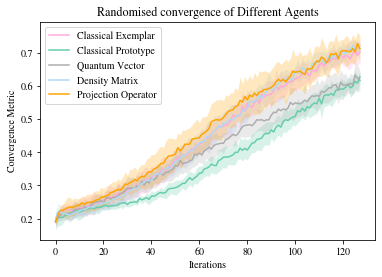

In [35]:
# Nonsense
PltWholeGame_prog('Classical Exemplar',millenialPink,aArgs={'a':a_exemplar,'ratioValue':0},Metric=RandomAccuracyMetric)
PltWholeGame_prog('Classical Prototype',mediumAquamarine,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':0},RAA=RAA_bp,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Quantum Vector',grey,aArgs={'a':a_quantumv,'ratioValue':0},RAA=RAA_quantumv,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Density Matrix',uranianBlue,aArgs={'a':a_quantum,'ratioValue':0},RAA=RAA_quantum_dm,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Projection Operator',orange,aArgs={'a':a_quantum,'ratioValue':0},RAA=RAA_quantum,Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Different Agents')
plt.legend()
plt.savefig('./Images/nonsense.pdf')
plt.show()

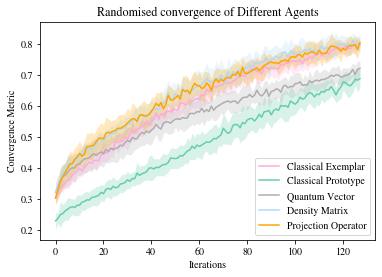

In [44]:
# Nonsense, with initilisation
PltWholeGame_prog('Classical Exemplar',millenialPink,aArgs={'a':a_exemplar,'ratioValue':1},Metric=RandomAccuracyMetric)
PltWholeGame_prog('Classical Prototype',mediumAquamarine,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Quantum Vector',grey,aArgs={'a':a_quantumv,'ratioValue':1},RAA=RAA_quantumv,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Density Matrix',uranianBlue,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum_dm,Metric=RandomAccuracyMetric)
PltWholeGame_prog('Projection Operator',orange,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=RandomAccuracyMetric)
plt.xlabel('Iterations')
plt.ylabel('Convergence Metric')
plt.title('Randomised convergence of Different Agents')
plt.legend()
plt.savefig('./Images/nonsense_init.pdf')
plt.show()

In [ ]:
Looking at truth rates affect on true convergence to dataset

In [104]:
# Full look at truth rates
ls = np.linspace(0,1,num=32)
ng = 2
results_et = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_exemplar,'ratioValue':i},Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_pt = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':i},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_qvt = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_quantumv,'ratioValue':i},RAA=RAA_quantumv,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_dmt = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_quantum,'ratioValue':i},RAA=RAA_quantum_dm,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])
results_qt = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_quantum,'ratioValue':i},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100],metricAll=False))[:,-1] for i in tqdm(ls)])

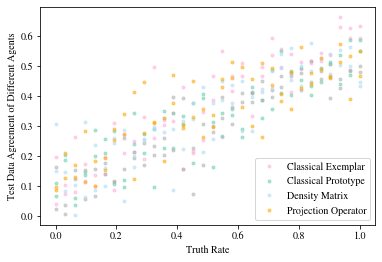

In [117]:
plt.plot(ls,results_et,c=millenialPink,linestyle='none',marker='.',alpha=0.5,label='Classical Exemplar')
#plt.plot(ls,np.mean(results_et,axis=1),label='Classical Exemplar',c=millenialPink)
plt.plot(ls,results_pt,c=mediumAquamarine,linestyle='none',marker='.',alpha=0.5,label='Classical Prototype')
#plt.plot(ls,np.mean(results_pt,axis=1),label='Classical Prototype',c=mediumAquamarine)
plt.plot(ls,results_qvt,c=grey,linestyle='none',marker='.',alpha=0.5,label='Density Matrix')
#plt.plot(ls,np.mean(results_qvt,axis=1),label='Density Matrix',c=grey)
plt.plot(ls,results_dmt,c=uranianBlue,linestyle='none',marker='.',alpha=0.5,label='Density Matrix')
#plt.plot(ls,np.mean(results_dmt,axis=1),label='Density Matrix',c=uranianBlue)
plt.plot(ls,results_qt,c=orange,linestyle='none',marker='.',alpha=0.5,label='Projection Operator')
#plt.plot(ls,np.mean(results_qt,axis=1),label='Projection Operator',c=orange)
plt.xlabel('Truth Rate')
plt.ylabel('Test Data Agreement of Different Agents')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./Images/truthConv_grounded_all.pdf')
plt.show()

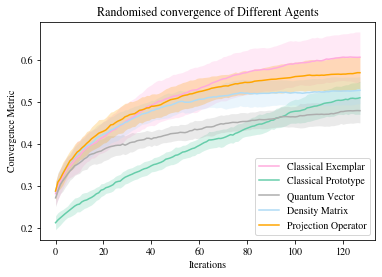

In [45]:
# Convergence on true natural colour cocepts grounded in the data
PltWholeGame_prog('Classical Exemplar',millenialPink,aArgs={'a':a_exemplar,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('Classical Prototype',mediumAquamarine,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('Quantum Vector',grey,aArgs={'a':a_quantumv,'ratioValue':1},RAA=RAA_quantumv,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('Density Matrix',uranianBlue,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum_dm,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('Projection Operator',orange,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp.pdf')
plt.show()

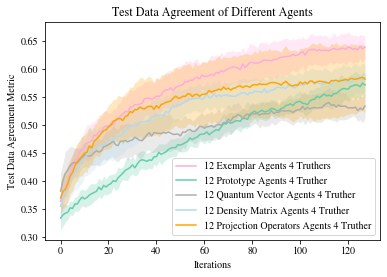

In [48]:
# Compare with parents
# Truth Comp
PltWholeGame_prog('12 Exemplar Agents 4 Truthers',millenialPink,nDifferentGames=8,nIterations=128,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_et,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('12 Prototype Agents 4 Truther',mediumAquamarine,nDifferentGames=8,nIterations=128,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_pt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('12 Quantum Vector Agents 4 Truther',grey,nDifferentGames=8,nIterations=128,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_qvt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('12 Density Matrix Agents 4 Truther',uranianBlue,nDifferentGames=8,nIterations=128,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_dmt,Metric=TestingAccuracy,X_test=Y_test[:100])
PltWholeGame_prog('12 Projection Operators Agents 4 Truther',orange,nDifferentGames=8,nIterations=128,aArgs={'e1':12,'e2':4,'a':0.2},RAA=RAA_qt,Metric=TestingAccuracy,X_test=Y_test[:100])
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp_withTruthers.pdf')
plt.show()

# Lots of colours
This section roughly looks at using more colours, and loading the full dataset. No exploration of subsets beyond the nine focal colours is considered in the report.

In [50]:
l_long = list(matplotlib.colors.CSS4_COLORS.keys())
print(l_long)

['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 

In [52]:
# Filter colours
r = 100 # truncation value, to uniformly distribute colour labels
# use r=-1 for all
Xc = X[:,-1]
Xi = []
l_long_1 = []
for k in l_long:
    x = np.where(Xc == k)
    if len(x[0]) > r:
        Xi.extend(x[0][:])
        print([len(x[0][:]),k])
        l_long_1.append(k)
l_long = l_long_1
Xi = np.array(Xi) # Array of indices of labels in l
Y = X[Xi]
np.random.shuffle(Y)
print(Y.shape)
print(Y[:10])
# Y is the refined dataset

[7108, 'aqua']
[2453, 'aquamarine']
[534, 'azure']
[4463, 'beige']
[4365, 'black']
[86598, 'blue']
[23123, 'brown']
[1487, 'chartreuse']
[340, 'chocolate']
[700, 'coral']
[901, 'crimson']
[7752, 'cyan']
[1104, 'fuchsia']
[2002, 'gold']
[1039, 'goldenrod']
[5502, 'gray']
[95003, 'green']
[10970, 'grey']
[3315, 'indigo']
[1494, 'khaki']
[8258, 'lavender']
[3407, 'lime']
[13917, 'magenta']
[5226, 'maroon']
[2186, 'navy']
[5399, 'olive']
[15845, 'orange']
[376, 'orchid']
[40056, 'pink']
[1811, 'plum']
[76778, 'purple']
[21498, 'red']
[4417, 'salmon']
[135, 'seagreen']
[363, 'sienna']
[112, 'silver']
[7579, 'tan']
[17807, 'teal']
[8288, 'turquoise']
[9724, 'violet']
[700, 'white']
[13364, 'yellow']
(517499, 7)
[[539930 25354 1267589963 39 232 29 'green']
 [815152 37440 1267669750 141 18 158 'violet']
 [988300 45027 1267770293 244 87 235 'pink']
 [801594 36920 1267664650 31 188 184 'cyan']
 [1046985 47612 1267803299 65 227 131 'green']
 [716404 33264 1267638381 100 197 96 'green']
 [92464 51

In [53]:
Y_long_train = Y[:50000]
Y_long_test = Y[-1000:]

In [ ]:
# Truth Comp
PltWholeGame('Classical Exemplar',millenialPink,nAgents=32,nDifferentGames=4,nIterations=64,aArgs={'a':a_exemplar,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_long_test[:100],l=l_long)
PltWholeGame('Classical Prototype',mediumAquamarine,nAgents=32,nDifferentGames=4,nIterations=64,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':1},RAA=RAA_bp,Metric=TestingAccuracy,X_test=Y_long_test[:100],l=l_long)
PltWholeGame('Quantum',orange,nAgents=32,nDifferentGames=4,nIterations=64,aArgs={'a':a_quantum,'ratioValue':1},RAA=RAA_quantum,Metric=TestingAccuracy,X_test=Y_long_test[:100],l=l_long)
plt.xlabel('Iterations')
plt.ylabel('Test Data Agreement Metric')
plt.title('Test Data Agreement of Different Agents')
plt.legend()
plt.savefig('./Images/truthComp_long.pdf')
plt.show()

In [ ]:
# Label Array - also used for quantum agent
ratioValue = 0
def RLA(l,pf,r=ratioValue,Y=Y_long_train):
    # r = ratio to use real data
    la = {l[i]:RE(pf) for i in np.random.randint(0,len(l),size=np.random.randint(0,len(l)))}
    for i in la:
        if np.random.random() < r:
            Xc = Y[:,-1]
            x = np.where(Xc == i)[0]
            #print(Xc[x])
            k = np.random.choice(x)
            la[i] = [float(Y[k,3])/255,float(Y[k,4])/255,float(Y[k,5])/255]
    return la
        

In [ ]:
def RLA_bp(l,pf,r,ratioValue=0,Y=Y_long_train):
    # r = ratio to use real data
    la = {l[i]:{'c':RE(pf),'sd':RSD(r)} for i in np.random.randint(0,len(l),size=np.random.randint(0,len(l)))}
    for i in la:
        if np.random.random() < ratioValue:
            Xc = Y[:,-1]
            x = np.where(Xc == i)[0]
            #print(Xc[x])
            k = np.random.choice(x)
            la[i]['c'] = [float(Y[k,3])/255,float(Y[k,4])/255,float(Y[k,5])/255]
    return la

In [ ]:
pf = PF(3)
l = ['blue','green','red','orange','yellow','purple']
agents = RAA_bp(pf,N=512,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,.75],'ratioValue':1})
agents = RAA=RAA_quantum(pf,N=64,l=l)
print(agents)
pprint(agents[-1].GetLabels())
for i in range(256):
    GameRound(agents,pf)
pprint(agents[-1].GetLabels())

In [ ]:
print(TestingAccuracy(agents,Y_long_test[:100]))
print(RandomAccuracyMetric(agents))
for i in range(20):
    print(Y_test[i])
    l = np.array([a.FindLabel(Y_long_test[i][3:6]/255) for a in agents])
    majorityLabel = Counter(l).most_common(1)
    majorityLabel = majorityLabel[0][0]
    print([Y_long_test[i][-1],majorityLabel])
    print(l)

In [ ]:
print(agents)

In [ ]:
print(l)

In [ ]:
# Training convergence
# ~Bifurcation~ plot of learning rates
ls = np.linspace(0,1,num=10)
results = np.array([np.array(WholeGame(nAgents=32,aArgs={'a':i,'ratioValue':0},Metric=TestingAccuracy,X_test=Y_long_test[:100],metricAll=False,l=l_long,Y=Y_long_train))[:,-1] for i in ls])
results_t = np.array([np.array(WholeGame(nAgents=32,aArgs={'a':i,'ratioValue':1},Metric=TestingAccuracy,X_test=Y_long_test[:100],metricAll=False,l=l_long,Y=Y_long_train))[:,-1] for i in ls])
plt.plot(ls,results,c=millenialPink,linestyle='none',marker='.',alpha=0.25,label='Random')
plt.plot(ls,results_t,c=orange,linestyle='none',marker='.',alpha=0.25,label='Full Truth')
plt.xlabel('Learning Rate')
plt.ylabel('Agent Exemplar Metric')
plt.savefig('./Images/learningRate_exemplar_testing_long.pdf')
plt.show()

## Full dataset

In [54]:
x = np.array(X[:,-1]).astype(str)
print('blue' in x)
l_all,l_all_counts = np.unique(x,return_counts=True)
print(x.shape)
print(l_all.shape)
print(l_all_counts)

True
(1048576,)
(69222,)
[1 1 1 ... 1 1 1]


In [55]:
l_all_2 = l_all[np.where(l_all_counts>9)]
l_all_2 = list(l_all_2)
l_all_2.remove('nan')
l_all_2 = np.array(l_all_2)
l_all_2_counts = l_all_counts[np.where(l_all_counts>9)]
print(l_all_2)
Y_all_2 = X[np.where(X[:,-1]) == l_all_2]
print(Y_all_2.shape)
print(np.where(X[:,-1]) == l_all_2)

[' blue' ' green' '#0000ff' ... 'zombie green' 'Зеленый' 'Синий']
(0, 1048576, 7)
False


/usr/local/anaconda3/envs/fyp/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/anaconda3/envs/fyp/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [56]:
'blue' in l_all_2

True

In [57]:
Xi = []
l_long_1 = []
ld = {}
for k in tqdm(l_all_2):
    x = np.where(Xc == k)
    Xi.extend(x[0][:])
    #print([len(x[0][:]),k])
    if k == 'blue':
        print(len(x[0][:]))
    ld[k] = len(x[0][:])
    l_long_1.append(k)
Y_all_2 = X[Xi]

86598



In [58]:
print(l)

['red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey']


In [59]:
ldc = dict(ld)
for i in range(30):
    x = MaxArgDict(ldc)
    print([x,ldc[x]])
    del ldc[x]
ldc = dict(ld)

['green', 95003]
['blue', 86598]
['purple', 76778]
['pink', 40056]
['brown', 23123]
['red', 21498]
['light blue', 18459]
['teal', 17807]
['orange', 15845]
['light green', 15729]
['magenta', 13917]
['yellow', 13364]
['grey', 10970]
['sky blue', 10912]
['lime green', 9829]
['violet', 9724]
['light purple', 9442]
['turquoise', 8288]
['lavender', 8258]
['cyan', 7752]
['dark green', 7595]
['tan', 7579]
['dark blue', 7431]
['aqua', 7108]
['forest green', 6287]
['bright green', 6109]
['mauve', 5988]
['gray', 5502]
['dark purple', 5481]
['olive', 5399]


In [60]:
print(ld['white'])

700


In [61]:
print(Y_all_2)

[[102800 5804 1267458722 ... 88 163 ' blue']
 [538204 25223 1267589380 ... 62 231 ' blue']
 [917536 41911 1267736285 ... 229 162 ' blue']
 ...
 [243767 12199 1267488788 ... 203 234 'Синий']
 [243367 12199 1267488732 ... 117 240 'Синий']
 [243357 12199 1267488730 ... 127 205 'Синий']]


In [62]:
l_all_2_counts = list(l_all_2_counts)
l_all_2_counts_sorted = np.sort(l_all_2_counts)[:2500]
print(l_all_2_counts_sorted.shape)

(2500,)


(array([250., 203.,   0., 172.,   0., 160.,   0., 133.,   0., 108.,   0.,
        100.,   0., 107.,   0.,  75.,   0.,  76.,   0.,  87.,   0.,  56.,
          0.,  55.,   0.,  55.,   0.,  58.,   0.,  39.,   0.,  48.,   0.,
         36.,   0.,  40.,   0.,  41.,   0.,  36.,   0.,  39.,   0.,  37.,
          0.,  28.,   0.,  33.,   0.,  25.,   0.,  27.,   0.,  19.,   0.,
         14.,   0.,  28.,   0.,  24.,   0.,  18.,   0.,  24.,   0.,  16.,
          0.,  15.,   0.,  17.,   0.,  14.,   0.,  15.,   0.,  16.,   0.,
         21.,   0.,   8.,   0.,  18.,   0.,  11.,   0.,   9.,   0.,  19.,
          0.,   8.,   0.,  13.,   0.,  15.,   0.,  11.,   0.,  14.,   0.,
          5.,   4.]),
 array([10.        , 10.5049505 , 11.00990099, 11.51485149, 12.01980198,
        12.52475248, 13.02970297, 13.53465347, 14.03960396, 14.54455446,
        15.04950495, 15.55445545, 16.05940594, 16.56435644, 17.06930693,
        17.57425743, 18.07920792, 18.58415842, 19.08910891, 19.59405941,
        20.0990099 ,

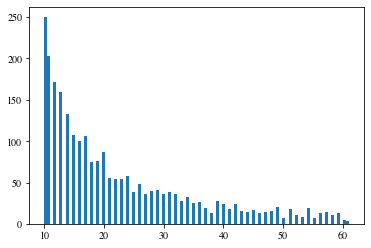

In [63]:
plt.hist(l_all_2_counts_sorted,101)

In [64]:
l_all = X[:-1]

In [ ]:
# Maybe I should do this but with at least another identical answer?
# or rather top 1000 labels?

# Misra-Gries
Although often obfuscated to graduate theoretical computer science classes, data streaming algorithms offer a dimension to reason and process large pools of noisy data with sparse focal points. Data streaming algorithms work on the premise that their data streams are so vast or costly that there is no looking back or querying. With the natural world, and the complexity of the human experience streaming algorithms become a useful constraint on modelling cognition and learning.

Streaming algorithms make computations on data in few passes. A data stream is a large finite array for which random access is not possible on. Imagine a flow of plates around a sushi bar conveyor belt - too cumbersome to remember all entrée entries or rather inconvenient to hoard all dishes on your table. The challenge is to make useful computations while staying seated at your table and watching the sushi slide by. For instance, without taking each sushi plate of a new colour, an algorithm that can estimate the total number of differently coloured sushi plates is desired. Formally a stream, $\vec{\sigma}=\langle{}a_1,...,a_m\rangle$ is made up on $m$ tokens that can take $n$ different values.

The Misra-Gries algorithm maintains a sketch of frequent elements to query majority elements. With a superparamter controlling memory usage, $k$, Misra-Gries is capable of finding all elements with more than $m ÷ k$ elements. Or, imagining, the m sushi plates with $n$ different colours on the conveyor belt, Misra-Gries constructs a record of the most-seen plate colours so that at the end it possible to query the quantity of plates of each colour with more than $m ÷ k$ entries in the stream without memorising the entire conveyor belt. $k$ is typically much smaller than $n$.

Agreeable Misra-Gries alters the mechanism by which the $k$ counters are incremented. No longer is there appearance importance, but rather that in their swarm that similar concept representations exist. If in the discrimination game a colour label is successfully distinguished, the listener agent’s trust of the label is incremented. New label introduction works the same as in the Misra-Gries algorithm, if less than $k$ are currently maintained then simply append, else decrement each counter by one and remove all zero counts.

Note that there is this imposition of agreeability that makes these findings different to simply the most common labels in the dataset. Imagine a concept, $\texttt{rife}$, that is common yet uniformly spread across our learning space. Although $\texttt{rife}$ would be a most popular label in the training set, agents in a swarm would not frequently agree in its discrimination because of other well-defined concepts, and the agents would not learn $\texttt{rife}$ as a focal element.

In [65]:
# Label Array
# Is this misra-gries??
ratioValue = 0
def RLA_mg(l,pf,r=ratioValue,Y=Y_long_train,k=3):
    # r = ratio to use real data
    la = {l[i]:RE(pf) for i in np.random.randint(0,len(l),size=np.random.randint(0,k))}
    for i in la:
        if np.random.random() < r:
            Xc = Y[:,-1]
            x = np.where(Xc == i)[0]
            #print(Xc[x])
            k = np.random.choice(x)
            la[i] = [float(Y[k,3])/255,float(Y[k,4])/255,float(Y[k,5])/255]
    return la

In [66]:
# Label Array
# Is this misra-gries??
ratioValue = 1
def RLA_mg(l,pf,r=ratioValue,Y=Y_train,k=5):
    # r = ratio to use real data
    k = 8
    la = {}
    #np.random.shuffle(Y)
    for i in np.random.choice(len(Y),size=k):
        if np.random.random() < r:
            x = Y[i,-1]
            if x not in la:
                la[x] = [float(Y[i,3])/255,float(Y[i,4])/255,float(Y[i,5])/255]
    return la

Naïve parents are implemented slightly differently when exploring the full dataset. The data is too vast and computationally demanding to create example concepts using strict predefined labels. Nor, in this case, do we trust the unique labels of the dataset. Prior, with the chosen reduced data, we have preimposed restrictions on labels that they resemble the form of either English language focal points or a more general list of similar colours. The labels are random, noisy, and non-uniform. Naïve parents instead randomly pick instances in the training set to initialise their data. Common labels will appear frequently, while rare and obscure labels appear infrequently.

In [67]:
# Agents
def RA_truther_mg(pf,aArgs={'a':0.12,'ratioValue':1},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    return AgentTruther(ExemplarLearningModel(LA=RLA_mg(l,pf,1,Y),a=a),pf=pf,l=l,RLA=RLA_mg,Y=Y)

#Random Agent Array
def RAA_truther_mg(pf,N=5,aArgs={'a':0.12,'ratioValue':1},l=l,Y=Y_train):
    agents = [RA_truther_mg(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

## Exemplar

In [68]:
# Agents
def RA_mg(pf,aArgs={'a':0.12,'ratioValue':1,'k':3},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    k = aArgs['k']
    return AgentMisraGries(ExemplarLearningModel(LA=RLA_mg(l,pf,aArgs['ratioValue'],Y,k),a=a),pf=pf,k=k)

#Random Agent Array
def RAA_mg(pf,N=5,aArgs={'a':0.12,'ratioValue':1,'k':3},l=l,Y=Y_train):
    #k = aArgs['k']
    agents = [RA_mg(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

In [69]:
def RAA_et_mg(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,Y=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    a = aArgs['a']
    k = aArgs['k']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_mg,RAA_truther_mg],aArgs=[{'a':a,'k':k,'ratioValue':1},{'a':0.12,'ratioValue':1}],Y=Y,l=l)

In [ ]:
# Truths
#l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('k = 2',millenialPink,nAgents=32,nDifferentGames=4,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':1,'k':2},Metric=TestingAccuracy,X_test=Y_test[:100],RAA=RAA_mg)
PltWholeGame('k = 4',mediumAquamarine,nAgents=32,nDifferentGames=4,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':1,'k':4},Metric=TestingAccuracy,X_test=Y_test[:100],RAA=RAA_mg)
PltWholeGame('k = 8',orange,nAgents=32,nDifferentGames=4,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':1,'k':8},Metric=TestingAccuracy,X_test=Y_test[:100],RAA=RAA_mg)
plt.xlabel('Iterations')
plt.ylabel('Testing Agreement Metric')
plt.title('Testing Agreement of Exemplar Misra-Gries Agents')
plt.legend()
plt.savefig('./Images/truthPlot_mg.pdf')
plt.show()

In [ ]:
# Truths
#l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('k = 8',millenialPink,nAgents=32,nDifferentGames=4,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':1,'k':2},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_mg,l=l_long)
PltWholeGame('k = 16',mediumAquamarine,nAgents=32,nDifferentGames=4,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':1,'k':4},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_mg,l=l_long)
PltWholeGame('k = 32',orange,nAgents=32,nDifferentGames=4,nIterations=128,aArgs={'a':a_exemplar,'ratioValue':1,'k':8},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_mg,l=l_long)
plt.xlabel('Iterations')
plt.ylabel('Testing Agreement Metric')
plt.title('Testing Agreement of Exemplar Misra-Gries Agents')
plt.legend()
plt.savefig('./Images/truthPlot_mg_long.pdf')
plt.show()
# Plot point where cross with complete random?
# More games to see if full truth is truly detrimental long term
# 45 mins for 256 iterations

In [ ]:
# Truths
#l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('k = 4',millenialPink,nDifferentGames=4,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':8},Metric=TestingAccuracy,X_test=Y_long_test[:100],RAA=RAA_et_mg,l=l,Y=Y_train)
PltWholeGame('k = 8',mediumAquamarine,nDifferentGames=4,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':16},Metric=TestingAccuracy,X_test=Y_long_test[:100],RAA=RAA_et_mg,l=l,Y=Y_train)
PltWholeGame('k = 16',orange,nDifferentGames=4,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':32},Metric=TestingAccuracy,X_test=Y_long_test[:100],RAA=RAA_et_mg,l=l,Y=Y_train)
plt.xlabel('Iterations')
plt.ylabel('Testing Agreement Metric')
plt.title('Testing Agreement of Exemplar Misra-Gries Agents for Lots of Labels with Parents')
plt.legend()
#plt.savefig('./Images/truthPlot_mg_parents.pdf')
plt.show()

In [ ]:
# Truths
#l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('k = 8',millenialPink,nDifferentGames=1,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':8},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_et_mg,l=l_long,Y=Y_long_train)
PltWholeGame('k = 16',mediumAquamarine,nDifferentGames=1,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':16},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_et_mg,l=l_long,Y=Y_long_train)
PltWholeGame('k = 32',orange,nDifferentGames=1,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':32},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_et_mg,l=l_long,Y=Y_long_train)
plt.xlabel('Iterations')
plt.ylabel('Testing Agreement Metric')
plt.title('Testing Agreement of Exemplar Misra-Gries Agents for Lots of Labels with Parents')
plt.legend()
plt.savefig('./Images/truthPlot_mg_long_parents.pdf')
plt.show()

In [ ]:
np.random.shuffle(Y_all_2)

In [ ]:
GameRound(agents,pf)

In [ ]:
agents = RAA_et_mg(pf,aArgs={'a':a_exemplar,'e1':1,'e2':1,'k':32},Y=Y_all_2,l=l_all_2)

In [ ]:
agents = RAA_qt_mg(pf,aArgs={'a':a_exemplar,'e1':1,'e2':1,'k':32},Y=Y_all_2,l=l_all_2)

In [ ]:
A = agents[1]
B = agents[0]
O = [RE(pf) for i in range(5)] # Random elements for N
o = O[-1]
print([A,B,O,o])

In [ ]:
a1 = AgentTruther(ExemplarLearningModel(),l=l_all_2,RLA=RLA_mg,Y=Y_all_2)

In [ ]:
DiscriminationGame(B,A,O,o)

In [ ]:
f = A.FindLabel(o)

In [ ]:
A.RLA

In [ ]:
A = RA

In [ ]:
A.RLA

In [ ]:
pf = PF(3)
agents = RAA_et_mg(pf,aArgs={'a':a_exemplar,'e1':256,'e2':32,'k':64},Y=Y_all_2,l=l_all_2)
pprint(agents[-0].GetLabels())
for i in tqdm(range(512)):
    GameRound(agents,pf)
pprint(agents[0].GetLabels())
print(agents[0].LAK)
print(agents[0].k)

In [ ]:
def clean(LAK):
    deletelist = []
    for a in LAK:
        if LAK[a] == 1:
            deletelist.append(a)
    for a in deletelist:
        del LAK[a]
    return LAK
        

In [ ]:
pprint(clean(agents[0].LAK))

In [ ]:
#%load_ext autoreload
#%autoreload 2

# Importing Libraries
from agentClass import *
#from learningModels import *

In [ ]:
pf = PF(3)
agents = RAA_et_mg(pf,aArgs={'a':a_exemplar,'e1':256,'e2':32,'k':128},Y=Y_all_2,l=l_all_2)
pprint(agents[-0].GetLabels())
print(agents[0].LAK)
for i in tqdm(range(2048)):
    GameRound(agents,pf)
pprint(agents[0].GetLabels())
print(agents[0].LAK)
print(agents[0].k)

In [ ]:
print(TestingAccuracy(agents[:255],Y_test[:1000]))
pprint(agents[0].LAK)
print(len(agents[0].LAK))

In [ ]:
ldc = dict(ld)
lakc = dict(agents[0].LAK)
for i in range(15):
    x = MaxArgDict(ldc)
    y = MaxArgDict(lakc)
    print([y,x])
    del ldc[x]
    del lakc[y]

In [ ]:
x = list(clean(agents[0].LAK).keys())
print(x)
print(l)
print(set(l)-set(x))
print(set(x)&set(l))

In [ ]:
# Truths
#l = ['blue','green','red','orange','yellow','purple']
PltWholeGame('k = 8',millenialPink,nDifferentGames=1,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':8},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_et_mg,l=l_all_2,Y=Y_all_2)
PltWholeGame('k = 16',mediumAquamarine,nDifferentGames=1,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':16},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_et_mg,l=l_all_2,Y=Y_all_2)
PltWholeGame('k = 32',orange,nDifferentGames=1,nIterations=8,aArgs={'a':a_exemplar,'e1':16,'e2':4,'k':32},Metric=TestingAccuracy,X_test=Y_long_test[:1000],RAA=RAA_et_mg,l=l_all_2,Y=Y_all_2)
plt.xlabel('Iterations')
plt.ylabel('Testing Agreement Metric')
plt.title('Testing Agreement of Exemplar Misra-Gries Agents for Lots of Labels with Parents')
plt.legend()
plt.savefig('./Images/truthPlot_mg_long_parents.pdf')
plt.show()

In [ ]:
pprint(agents[0].LAK)

In [ ]:
print(TestingAccuracy(agents[:],Y_long_test[:100]))

## Prototype

In [70]:
# Not convinced there's anything different in the mg version?
def RLA_bp_mg(l,pf,r,ratioValue=0,Y=Y_train):
    # r = ratio to use real data
    la = {l[i]:{'c':RE(pf),'sd':RSD(r)} for i in np.random.randint(0,len(l),size=np.random.randint(0,len(l)))}
    for i in la:
        if np.random.random() < ratioValue:
            Xc = Y[:,-1]
            x = np.where(Xc == i)[0]
            #print(Xc[x])
            k = np.random.choice(x)
            la[i]['c'] = [float(Y[k,3])/255,float(Y[k,4])/255,float(Y[k,5])/255]
    return la

In [71]:
# Label Array
# Is this misra-gries??
ratioValue = 1
def RLA_bp_mg(l,pf,r=ratioValue,Y=Y_train,k=5):
    # r = ratio to use real data
    k = 8
    la = {}
    #np.random.shuffle(Y)
    for i in np.random.choice(len(Y),size=k):
        x = Y[i,-1]
        if x not in la:
            la[x] = {}
            la[x]['c'] = [float(Y[i,3])/255,float(Y[i,4])/255,float(Y[i,5])/255]
            la[x]['sd'] = np.random.random()
    return la

In [ ]:
RLA_bp_mg(l,PF(3),k=10)

In [72]:
# Agents_BayesianPrototype
def RA_bp_mg(pf,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':0,'k':8},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    a_sd = aArgs['a_sd']
    r = aArgs['r']
    k = aArgs['k']
    return AgentMisraGries(BayesianPrototypeLearningModel(LA=RLA_bp_mg(l,pf,r=aArgs['ratioValue'],Y=Y),a=a,a_sd=a_sd),pf=pf,k=k)

#Random Agent Array
def RAA_bp_mg(pf,N=5,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':0,'k':8},l=l,Y=Y_train):
    agents = [RA_bp_mg(pf,aArgs,l=l,Y=Y) for i in range(N)] # an array of N random agents
    return agents

In [73]:
def RAA_pt_mg(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4,'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,1],'k':5},l=l,Y=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    a = aArgs['a']
    a_sd = aArgs['a_sd']
    r = aArgs['r']
    k = aArgs['k']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_bp_mg,RAA_truther_mg],aArgs=[{'a':a,'a_sd':a_sd,'k':k,'ratioValue':1,'r':r},{'a':0.12,'ratioValue':1}],Y=Y,l=l)

## Quantum

In [74]:
# Agents
def RA_q_mg(pf,aArgs={'a':0.12,'ratioValue':1,'k':3},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    k = aArgs['k']
    return AgentMisraGries(QuantumAgent(LA=RLA_mg(l,pf,aArgs['ratioValue'],Y,k),a=a),pf=pf,k=k)

#Random Agent Array
def RAA_q_mg(pf,N=5,aArgs={'a':0.12,'ratioValue':1,'k':3},l=l,Y=Y_train):
    #k = aArgs['k']
    agents = [RA_q_mg(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

In [75]:
def RAA_qt_mg(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,Y=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    a = aArgs['a']
    k = aArgs['k']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_q_mg,RAA_truther_mg],aArgs=[{'a':a,'k':k,'ratioValue':1},{'a':0.12,'ratioValue':1}],Y=Y,l=l)

### Density Matrix Agents

In [76]:
# Agents
def RA_dm_mg(pf,aArgs={'a':0.12,'ratioValue':1,'k':3},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    k = aArgs['k']
    return AgentMisraGries(QuantumAgent_dm(LA=RLA_mg(l,pf,aArgs['ratioValue'],Y,k),a=a),pf=pf,k=k)

#Random Agent Array
def RAA_dm_mg(pf,N=5,aArgs={'a':0.12,'ratioValue':1,'k':3},l=l,Y=Y_train):
    #k = aArgs['k']
    agents = [RA_dm_mg(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

In [77]:
def RAA_dmt_mg(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,Y=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    a = aArgs['a']
    k = aArgs['k']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_dm_mg,RAA_truther_mg],aArgs=[{'a':a,'k':k,'ratioValue':1},{'a':0.12,'ratioValue':1}],Y=Y,l=l)

### quantum Vector

In [78]:
# Agents
def RA_qv_mg(pf,aArgs={'a':0.12,'ratioValue':1,'k':3},l=l,Y=Y_train):
    '''
    Create an agent with a random selection of labels with random exemplars
    '''
    a = aArgs['a']
    k = aArgs['k']
    return AgentMisraGries(QuantumVectorAgent(LA=RLA_mg(l,pf,aArgs['ratioValue'],Y,k),a=a),pf=pf,k=k)

#Random Agent Array
def RAA_qv_mg(pf,N=5,aArgs={'a':0.12,'ratioValue':1,'k':3},l=l,Y=Y_train):
    #k = aArgs['k']
    agents = [RA_qv_mg(pf,aArgs,l,Y) for i in range(N)] # an array of N random agents
    return agents

In [79]:
def RAA_qvt_mg(pf=PF(3),nAgents=None,aArgs={'e1':4,'e2':4},l=l,Y=Y_train):
    e1 = aArgs['e1']
    e2 = aArgs['e2']
    a = aArgs['a']
    k = aArgs['k']
    return RAA_ensemble(pf=PF(3),nAgents=[e1,e2],RAAs=[RAA_qv_mg,RAA_truther_mg],aArgs=[{'a':a,'k':k,'ratioValue':1},{'a':0.12,'ratioValue':1}],Y=Y,l=l)

## Plots
Several different types of graph. Plotting the running of a single swarm, or comparison between swarm learning agent types, or utility in moelling focalcolours as $k$ varies.

In [80]:
# Return the iterative $k$ remeberd colours for several games, and keep in a dictioanry type datastruct
def MGColsDict(RAA,nDifferentGames=nDG,nIterations=nI,nAgents=nA,aArgs={'a':0.12,'ratioValue':1,'k':32,'e1':64,'e2':64},l=l,Y=Y_train,pf=PF(3)):
    resultsWhole = {}
    for i in tqdm(range(nDifferentGames),leave=False):
        rTemp = {}
        agents = RAA(pf,nAgents,aArgs,l,Y)
        for j in range(nIterations):
            cols = {}
            for a in agents:
                try:
                    for c in a.LAK:
                        cols[c] = cols.get(c,0) + a.LAK[c]
                except:
                    None #print('error')
            for c in set(list(cols.keys()))|set(list(rTemp.keys())):
                rTemp[c] = np.append(rTemp.get(c,np.zeros(j)),cols.get(c,0))
                #print(len(rTemp[c]))
            GameRound(agents,pf)
        for c in set(list(rTemp.keys()))|set(list(resultsWhole.keys())):
            #print(c)
            #print(resultsWhole.get(c,np.zeros((i,nIterations))))
            #print(rTemp.get(c,np.zeros(nIterations)))
            resultsWhole[c] = np.append(resultsWhole.get(c,np.zeros((i,nIterations))),[rTemp.get(c,np.zeros(nIterations))],axis=0)
    return resultsWhole

### Iterations
Looking at how colours are learnt in iterative discrimination games

In [81]:
x = MGColsDict(RAA_et_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=16,nIterations=512)
#pprint(x.keys())

KeyboardInterrupt: 

In [ ]:
al = 1/16

for c in set(list(x.keys()))&set(l_long):
    resultsAvg = np.mean(x[c],axis=0)
    #print(resultsAvg)
    resultsVar = np.sqrt(np.var(x[c],axis=0))
    plt.plot(range(resultsAvg.shape[0]),resultsAvg,c=c,label=c)
    # Use a # of s.d.?
    plt.fill_between(range(resultsAvg.shape[0]),resultsAvg-resultsVar,resultsAvg+resultsVar,color=c,alpha=al,linewidth=0.0)
    #plt.plot(y,linestyle='none',marker='.',c=c,alpha=al)
plt.ylabel('$k$-values')
plt.xlabel('Iteration')
plt.savefig('./Images/mgColsEx.pdf')
plt.show()

In [ ]:
print(x['blue'])

In [ ]:
print(len(l_all_2))

In [ ]:
al = 1/16

for c in set(list(x.keys()))&set(l_long):
    resultsAvg = np.mean(x[c],axis=0)
    #print(resultsAvg)
    resultsVar = np.sqrt(np.var(x[c],axis=0))
    plt.plot(range(resultsAvg.shape[0]),resultsAvg,c=c,label=c)
    # Use a # of s.d.?
    plt.fill_between(range(resultsAvg.shape[0]),resultsAvg-resultsVar,resultsAvg+resultsVar,color=c,alpha=al,linewidth=0.0)
    #plt.plot(y,linestyle='none',marker='.',c=c,alpha=al)
plt.ylim(bottom=1)
plt.yscale('log')
plt.show()

### $k$-bifurcation
Considering how the dynamics of colours learnt changes as superparameter $k$ is changed. It might be expected that for each additional bin a new colour might be added, but this is not observed.

In [83]:
def kMGResults(k):
    return MGColsDict(RAA_et_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=16,nIterations=256,aArgs={'a':0.12,'ratioValue':1,'k':k,'e1':32,'e2':32},pf=PF(3))

In [84]:
ks = list(range(128))
results_k = [kMGResults(k) for k in tqdm(ks)]

KeyboardInterrupt: 

In [ ]:
al = 1/16

for c in l_long:
    try:
        x = np.array([r[c] for r in results_k])
        resultsAvg = np.mean(x[:,:,-1],axis=1)
        #print(resultsAvg)
        resultsVar = np.sqrt(np.var(x[:,:,-1],axis=1))
        plt.plot(ks,resultsAvg,c=c,label=c)
        # Use a # of s.d.?
        plt.fill_between(ks,resultsAvg-resultsVar,resultsAvg+resultsVar,color=c,alpha=al,linewidth=0.0)
        #plt.plot(y,linestyle='none',marker='.',c=c,alpha=al)
    except:
        None
plt.ylabel('')        
plt.xlabel('$k$')
plt.savefig('./Images/mgKBigEx.pdf')
plt.show()

In [ ]:
al = 1/16

for c in l_long:
    try:
        x = np.array([r[c] for r in results_k])
        resultsAvg = np.mean(x[:,:,-1],axis=1)
        #print(resultsAvg)
        resultsVar = np.sqrt(np.var(x[:,:,-1],axis=1))
        plt.plot(ks,resultsAvg,c=c,label=c)
        # Use a # of s.d.?
        plt.fill_between(ks,resultsAvg-resultsVar,resultsAvg+resultsVar,color=c,alpha=al,linewidth=0.0)
        #plt.plot(y,linestyle='none',marker='.',c=c,alpha=al)
    except:
        None
plt.ylim(bottom=1)
plt.yscale('log')
plt.savefig('./Images/kBifExemCols.pdf')
plt.show()

### Focal Colours
Similar to above section, but instead an analysis of ability to locate focal colours as $k$ is changed.

In [85]:
def Percentage(x,l=l):
    return len(set(x)&set(l))/len(l)

In [86]:
def MGColsDict(RAA,nDifferentGames=nDG,nIterations=nI,nAgents=nA,aArgs={'a':0.12,'ratioValue':1,'k':64,'e1':4,'e2':4},l=l,Y=Y_train,pf=PF(3)):
    resultsWhole = {}
    for i in range(nDifferentGames):
        rTemp = {}
        agents = RAA(pf,nAgents,aArgs,l,Y)
        for j in range(nIterations):
            cols = {}
            for a in agents:
                try:
                    for c in a.LAK:
                        cols[c] = cols.get(c,0) + a.LAK[c]
                except:
                    None #print('error')
            for c in set(list(cols.keys()))|set(list(rTemp.keys())):
                rTemp[c] = np.append(rTemp.get(c,np.zeros(j)),cols.get(c,0))
                #print(len(rTemp[c]))
            GameRound(agents,pf)
        for c in set(list(rTemp.keys()))|set(list(resultsWhole.keys())):
            #print(c)
            #print(resultsWhole.get(c,np.zeros((i,nIterations))))
            #print(rTemp.get(c,np.zeros(nIterations)))
            resultsWhole[c] = np.append(resultsWhole.get(c,np.zeros((i,nIterations))),[rTemp.get(c,np.zeros(nIterations))],axis=0)
    return resultsWhole

In [91]:
def FocalPercentage(RAA,nDifferentGames=nDG,nIterations=nI,nAgents=nA,aArgs={'a':0.12,'ratioValue':1,'k':64,'e1':4,'e2':4},l=l_all_2,Y=Y_all_2,pf=PF(3),l_focal=l):
    y = []
    for i in tqdm(range(nDifferentGames),leave=False):
        x = []
        agents = RAA(pf,nAgents,aArgs,l,Y)
        for j in range(nIterations):
            GameRound(agents,pf)
        for a in agents:
            try:
                x.append(Percentage(list(a.LAK.keys()),l_focal))
            except:
                None
        y.append(np.mean(x))
    return np.mean(y)

In [95]:
def FocalPercentages(RAA,nDifferentGames=nDG,nIterations=nI,nAgents=nA,aArgs={'a':0.12,'ratioValue':1,'k':64,'e1':4,'e2':4},l=l_all_2,Y=Y_all_2,pf=PF(3),l_focal=l,k=64):
    y_11 = []
    y_9 = []
    aArgs['k'] = k
    for i in tqdm(range(nDifferentGames),leave=False):
        x_11 = []
        x_9  = []
        agents = RAA(pf,nAgents,aArgs,l,Y)
        for j in range(nIterations):
            GameRound(agents,pf)
        for a in agents:
            try:
                x_11.append(Percentage(list(a.LAK.keys()),l_11))
                x_9.append(Percentage(list(a.LAK.keys()),l_9))
            except:
                None
        y_11.append(np.mean(x_11))
        y_9.append(np.mean(x_9))
    return [np.mean(y_9),np.sqrt(np.var(y_9))],[np.mean(y_11),np.sqrt(np.var(y_11))]

In [96]:
def FocalPercentagesPlot(RAA,nDifferentGames,nIterations,nk,c,label,aArgs={'a':a_exemplar,'ratioValue':1,'e1':4,'e2':4}):
    results = [FocalPercentages(RAA,l=l_all_2,Y=Y_all_2,nDifferentGames=nDifferentGames,nIterations=nIterations,aArgs=aArgs,pf=PF(3),k=k) for k in tqdm(range(nk))]
    results = np.array(results)
    results_9 = results[:,0]
    results_11 = results[:,1]
    results_9_var = results_9[:,1]
    results_11_var = results_11[:,1]
    plt.plot(range(n),results_9[:,0],c=c,label=label)
    plt.fill_between(range(n),results_9[:,0]-results_9_var,results_9[:,0]+results_9_var,color=c,alpha=0.125,linewidth=0.0)
    plt.plot(range(n),results_11[:,0],c=c,linestyle='--')
    plt.fill_between(range(n),results_11[:,0]-results_11_var,results_11[:,0]+results_11_var,color=c,alpha=0.125,linewidth=0.0)
    

In [97]:
k = 128
ng = 4
ni = 256
x_9,x_11 = FocalPercentages(RAA_et_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=32,nIterations=256,aArgs={'a':a_exemplar,'ratioValue':1,'e1':4,'e2':4},pf=PF(3))


NameError: name 'mean' is not defined

In [ ]:
print(x_9)

In [ ]:
# Full look at truth rates
ls = np.linspace(0,1,num=32)
ng = 2
results_et = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_exemplar,'ratioValue':i},Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])
results_pt = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,0.75],'ratioValue':i},RAA=RAA_bp,Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])
results_qvt = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_quantumv,'ratioValue':i},RAA=RAA_quantumv,Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])
results_dmt = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_quantum,'ratioValue':i},RAA=RAA_quantum_dm,Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])
results_qt = np.array([np.array(WholeGame(nDifferentGames=ng,aArgs={'a':a_quantum,'ratioValue':i},RAA=RAA_quantum,Metric=RandomAccuracyMetric,metricAll=False))[:,-1] for i in tqdm(ls)])

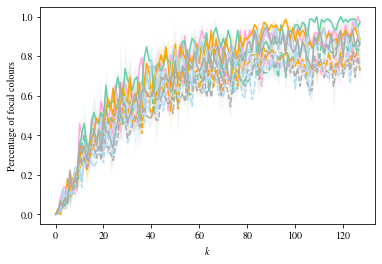

In [103]:
# n=128,ni=256,ng=1 took 4 hours!
n = 128
ng = 2
ni = 256
FocalPercentagesPlot(RAA_et_mg,ng,ni,n,millenialPink,'Exemplar')
FocalPercentagesPlot(RAA_pt_mg,ng,ni,n,mediumAquamarine,'Prototype',aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,1],'ratioValue':1,'k':k,'e1':4,'e2':4})
FocalPercentagesPlot(RAA_qt_mg,ng,ni,n,orange,'Quantum',aArgs={'a':a_quantum,'ratioValue':1,'k':k,'e1':4,'e2':4})
FocalPercentagesPlot(RAA_dmt_mg,ng,ni,n,uranianBlue,'Quantum',aArgs={'a':a_quantum,'ratioValue':1,'k':k,'e1':4,'e2':4})
FocalPercentagesPlot(RAA_qvt_mg,ng,ni,n,grey,'Quantum',aArgs={'a':a_quantum,'ratioValue':1,'k':k,'e1':4,'e2':4})
plt.ylabel('Percentage of focal colours')
plt.xlabel('$k$')
plt.savefig('./Images/focalColMG.pdf')


In [ ]:
# Plot Graph of avg. # focal colours learnt 
n = 16
ng = 8
ni = 256
results_ekt = [FocalPercentages(RAA_et_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=ng,nIterations=ni,aArgs={'a':a_exemplar,'ratioValue':1,'k':k,'e1':4,'e2':4},pf=PF(3)) for k in tqdm(range(n))]
results_ekt = np.array(results_ekt)
results_ekt_9 = results_ekt[:,0]
results_ekt_11 = results_ekt[:,1]
plt.plot(range(n),results_ekt_9[:,0],c=millenialPink,label='Exemplar')
    # Use a # of s.d.?
plt.fill_between(range(n),results_ekt_9[:,0]-results_ekt_9[:,1],results_ekt_9[:,0]+results_ekt_9[:,1],color=millenialPink,alpha=0.25,linewidth=0.0)


In [ ]:
n = 8
ng = 4
ni = 256
results_ekt = [FocalPercentage(RAA_et_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=ng,nIterations=ni,aArgs={'a':a_exemplar,'ratioValue':1,'k':k,'e1':4,'e2':4},pf=PF(3)) for k in tqdm(range(n))]
results_pkt = [FocalPercentage(RAA_pt_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=ng,nIterations=ni,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,1],'ratioValue':1,'k':k,'e1':4,'e2':4},pf=PF(3)) for k in tqdm(range(n))]
results_qkt = [FocalPercentage(RAA_qt_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=ng,nIterations=ni,aArgs={'a':a_quantum,'ratioValue':1,'k':k,'e1':4,'e2':4},pf=PF(3)) for k in tqdm(range(n))]
results_dmkt = [FocalPercentage(RAA_dmt_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=ng,nIterations=ni,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,1],'ratioValue':1,'k':k,'e1':4,'e2':4},pf=PF(3)) for k in tqdm(range(n))]

In [ ]:
results_dmkt = [FocalPercentage(RAA_dmt_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=4,nIterations=256,aArgs={'a':a_prototype,'a_sd':a_sd_prototype,'r':[0,1],'ratioValue':1,'k':k,'e1':4,'e2':4},pf=PF(3)) for k in tqdm(range(n))]


In [ ]:
plt.plot(list(range(n)),results_ekt,c=millenialPink)
plt.plot(list(range(n)),results_pkt,c=mediumAquamarine)
plt.plot(list(range(n)),results_qkt,c=orange)
plt.plot(list(range(n)),results_dmkt,c=uranianBlue)

In [90]:
print(l)
l_11 = list(l)
l_11.extend(['white','black'])
print([l,l_11])
l_9 = list(l)
print(l_9)

['red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey']
[['red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey'], ['red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey', 'white', 'black']]
['red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey']


In [ ]:
results_ekt_11 = [FocalPercentage(RAA_et_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=4,nIterations=256,aArgs={'a':a_exemplar,'ratioValue':1,'k':k,'e1':4,'e2':4},pf=PF(3),l_focal=l_11) for k in tqdm(range(n))]

In [98]:
# For a single game return dict of whether 11 focal colours are in final agent reps
def FocalColsPercentage(RAA,nIterations=nI,nAgents=nA,aArgs={'a':0.12,'ratioValue':1,'k':64,'e1':4,'e2':4},l=l_all_2,Y=Y_all_2,pf=PF(3),k=64):
    l_focal = ['red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey', 'white', 'black']
    aArgs['k'] =  k
    agents = RAA(pf,nAgents,aArgs,l,Y)
    x = {}
    for j in range(nIterations):
        GameRound(agents,pf)
    for a in agents:
        try:
            for c in l_focal:
                x[c] = np.append(x.get(c,[]),Percentage(list(a.LAK.keys()),[c]))
        except:
            None
    for c in x:
        x[c] = np.mean(x[c])
    return x

In [ ]:
FocalColsPercentage(RAA_et_mg,l=l_all_2,Y=Y_all_2,nIterations=ni,aArgs={'a':a_exemplar,'ratioValue':1,'k':16,'e1':4,'e2':4},pf=PF(3))

In [99]:
# run FocalColsPercentage over several games for exemplar
def FocalColsPercentages_exemplar(nDifferentGames=ng,nIterations=512,k=32):
    x = {}
    for i in tqdm(range(nDifferentGames),leave=False):
        y = FocalColsPercentage(RAA_et_mg,nIterations=nIterations,k=k)
        for c in y:
            x[c] = np.append(x.get(c,[]),y[c])
    for c in x:
        x[c] = [np.mean(x[c]),np.var(x[c])]
    return x

In [ ]:
print(ng)

In [100]:
# nk=128,ng=32, 90mins

nk = 128
ng = 32

y = {}
y_var = {}
for i in tqdm(range(nk)):
    x = FocalColsPercentages_exemplar(nDifferentGames=ng,k=i)
    for c in x:
        y[c] = np.append(y.get(c,np.zeros(i)),x[c][0])
        y_var[c] = np.append(y_var.get(c,np.zeros(i)),x[c][1])
for c in y:
    plt.plot(list(range(nk)),y[c],c=c)
    plt.fill_between(range(nk),y[c]-y_var[c],y[c]+y_var[c],color=c,alpha=0.125,linewidth=0.0)
plt.savefig('./Images/mgFocalCols.pdf')

KeyboardInterrupt: 


['red', 44.29379477160666]
['green', 10.023136111491215]
['yellow', 71.25321759952111]
['blue', 10.995958336220236]
['brown', 41.18098862604333]
['orange', 60.09643420637425]
['pink', 23.772418613940484]
['purple', 12.402354841230562]
['grey', 86.80291704649044]
['white', 1360.3257142857142]
['black', 218.150744558992]


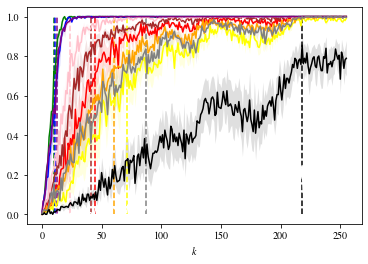

In [102]:
# nk=128,ng=32, 90mins

nk = 256
ng = 64

m = Y_all_2.shape[0]

y = {}
y_var = {}
for i in tqdm(range(nk)):
    x = FocalColsPercentages_exemplar(nDifferentGames=ng,k=i)
    for c in x:
        y[c] = np.append(y.get(c,np.zeros(i)),x[c][0])
        y_var[c] = np.append(y_var.get(c,np.zeros(i)),x[c][1])
for c in y:
    plt.plot(list(range(nk)),y[c],c=c)
    plt.fill_between(range(nk),y[c]-y_var[c],y[c]+y_var[c],color=c,alpha=0.125,linewidth=0.0)
    a = m/ld[c]
    print([c,a])
    if (a < nk):
        plt.vlines(a,ymin=0,ymax=1,colors=[c],linestyle='dashed')
        
plt.xlabel('$k$')
plt.savefig('./Images/mgFocalCols.pdf')

In [ ]:
print(Y_all_2.shape)


In [ ]:
for c in y:
    plt.plot(list(range(nk)),y[c],c=c)
    plt.fill_between(range(nk),y[c]-y_var[c],y[c]+y_var[c],color=c,alpha=0.125,linewidth=0.0)

In [ ]:
results_ekt_blue = [FocalPercentage(RAA_et_mg,l=l_all_2,Y=Y_all_2,nDifferentGames=8,nIterations=256,aArgs={'a':a_exemplar,'ratioValue':1,'k':k,'e1':4,'e2':4},pf=PF(3),l_focal=['blue']) for k in tqdm(range(n))]

In [ ]:
plt.plot(list(range(n)),results_ekt_blue,c='blue')
plt.plot(list(range(n)),results_ekt_11)

# Colour space plots
Again, not used in the report. But tools to visualise the colour spaces created by different learning model's agents by brute forcing classification across RGB space.

In [ ]:
def PlotColourSpace(agent,ax,n=16,angle=30):
    for x in tqdm(range(n)):
        for y in range(n):
            for z in range(n):
                x,y,z = [x,y,z]
                c = agent.FindLabel([x,y,z])
                try:
                    ax.scatter(x,y,z,c=c,alpha=1/2)
                except:
                    print(c)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    #ax.set_xlabel('r')
    #ax.set_ylabel('g')
    #ax.set_zlabel('b')
    ax.view_init(30,angle)
    #plt.tight_layout()
    #return fig,ax

In [ ]:
from agentClass import *

In [ ]:
print(l)

In [ ]:
print([nA,nI])
pf = PF(3)
agents = RAA_quantum(pf,N=nA,aArgs={'a':a_quantum,'ratioValue':1},l=l,Y=Y_train)
for i in tqdm(range(128)):
    GameRound(agents,pf)

In [ ]:
print(TestingAccuracy(agents,Y_test[:100]))

In [ ]:
print(TestingAccuracy(agents,Y_test[:100]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
PlotColourSpace(agents[0],ax)

In [ ]:
fig, axs = plt.subplots(1,3,subplot_kw=dict(projection="3d"),figsize=(15,5))
angles = [30,150,270]
for i in range(3):
    PlotColourSpace(agents[0],axs[i],angle=angles[i])
plt.tight_layout()
plt.savefig('./images/quantumColourSpace.pdf')

In [ ]:
pf = PF(3)
agents_dm = RAA_quantum_dm(pf,N=nA,aArgs={'a':a_quantum,'ratioValue':1},l=l,Y=Y_train)
for i in tqdm(range(128)):
    GameRound(agents_dm,pf)

In [ ]:
print(TestingAccuracy(agents_dm,Y_test[:100]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
PlotColourSpace(agents_dm[0],ax)

In [ ]:
fig, axs = plt.subplots(1,3,subplot_kw=dict(projection="3d"),figsize=(15,5))
angles = [30,150,270]
for i in range(3):
    PlotColourSpace(agents_dm[0],axs[i],angle=angles[i])
plt.tight_layout()
plt.savefig('./Images/quantumColourSpace_dm.pdf')